# Deep learning model training and single neuron MEI synthesis procedure

### Experimental paradigm background:
The **inception loop experimental paradigm** in this project involves a **generation phase** (i.e. data collection and neuronal spike clustering) and a **verification phase** (i.e. model training, MEI (Most Exciting Input) synthesis, and real-time in vivo verification of MEIs). This notebook implements the verification phase of the experiment. 

### Overview of the procedure in this notebook:
This notebook uses a pre-trained **ResNet50** CNN model as a feature extractor for the ImageNet natural images that were shown during the electrophysiology experiment. A **spike-prediction readout function** is attached to a specific layer of this ResNet model, and this readout function is trained to identify the most relevant region of the input image that is most predictive of neuronal spiking activity. The trained model therefore outputs the **predicted spike count** of a neuron in response to arbitrary image inputs. 

This trained model is utilized to synthesize new images (starting from a white noise input and iteratively updating via gradient ascent) with the goal of maximally activating a neuron of interest (i.e. producing the highest number of spikes compared to all other images). These synthetic images are called **MEIs (Most Exciting Inputs)**, which are subsequently verified in the real brain by showing them to the animal and verifying that the ground truth neuronal activity matches the predicted activity. These MEIs illustrate the specific features that neurons care about (i.e. what types of features they selectively process). This helps us characterize the functions of different parts of the visual cortex. 


## Import necessary libraries and repos and connect to the database


In [ ]:
#Import modules for configuration setup and data preprocessing
from src import setup_configuration, get_filename, get_dotmap_position, process_mat_file, save_as_pickle, mei_utils

# Connect to the database and set configuration variables
fetch_download_path = setup_configuration()

In [ ]:
from copy import copy
from torch import load
import random
import math
import os
from os import listdir
from os.path import isfile, join
from datetime import date
import torch
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy
from scipy import ndimage
from skimage import morphology
from skimage.transform import rescale
from scipy.io import savemat
import scipy.io as sio
import warnings
from copy import copy

schema = dj.schema("nnfabrik_toy_V4")

from nnfabrik.main import *
import nnfabrik
from nnfabrik import main, builder

from mei import mixins
from mei import legacy

import nnvision
from nnvision.tables.main import Recording
from nnvision.tables.from_nnfabrik import DataInfo, TrainedModel, TrainedHyperModel, TrainedTransferModel, SharedReadoutTrainedModel
from nnvision.tables.from_mei import MEI, MEIShared, MEISeed, Method, Ensemble, SharedReadoutTrainedEnsembleModel, MethodGroup, MEIObjective, MEITargetUnits, MEITargetFunctions, MEITextures, MEIPrototype
from nnvision.tables.from_mei import TransferEnsembleModel, MEITransfer
from nnvision.tables.ensemble_scores import TestCorrelationEnsembleScore, CorrelationToAverageEnsembleScore
from nnvision.tables.measures import ExplainableVar
from nnvision.tables.scores import TestCorrelationScore, CorrelationToAverageScore
from nnvision.datasets.utility import get_validation_split, ImageCache, get_cached_loader, get_fraction_of_training_images, get_crop_from_stimulus_location
from nnvision.utility.experiment_helpers.image_processing import (rescale_image, 
                                                                  re_norm, rescale, 
                                                                  transform_image, 
                                                                  normalize_image,
                                                                  get_norm,
                                                                  shift_image_based_on_masks,
                                                                 )
from nnvision.utility.experiment_helpers.mei_masks import generate_mask
from mei_shifting import shift_based_on_rf, center_of_mass, shift



# Settings and Parameters

### Model training and stimulus parameters

In [ ]:
# Constants
TRAINING_IMG_MEAN = 124.34
TRAINING_IMG_STD = 70.28
IMAGE_HEIGHT, IMAGE_WIDTH = 80, 80

# Derived constants
Z_0 = (0 - TRAINING_IMG_MEAN) / TRAINING_IMG_STD
Z_255 = (255 - TRAINING_IMG_MEAN) / TRAINING_IMG_STD


# Configuration for model and data processing
param_config = {
    'method_hash': "a9277c97184765592390fc3bd0ed5cda",
    'num_seeds': 10,
    'num_models': 2,
    'n_selected_stimuli': 2,
    'n_positions': 21,
    'n_best_images_selected': 7,
    'mouse_imagenet_scaling_factor': 1.64,
    'zscore_thresh': 0.35,
    'gaussian_sigma': 2,
    'final_image_norm': 19,
    'shift_padding': 10
}

# Extract experimental data and populate it into the database

#### Fetch the dataset .mat file (data collection/initial processing happens in MATLAB) and convert the file to .pickle for easy python handling

In [13]:
#Take data file (.mat), dump contents in pickle file, and save to multiple locations
!python data_preprocessing.py

#Load the processed pickle file
todays_file = 'CSRF19_V4_3753367464516.pickle'
filename = '/data/monkey/toliaslab/CSRF19_V4/sua_data/' + todays_file

with open(filename, 'rb') as f:
    data = pickle.load(f)
    print(data)


/mnt/lab/users/kelli/mei/V4_SUA_closed_loop/CSRF19_V4_3753367464516.mat
(30, 3753367464516, array([13492,  8293, 17333, ..., 13304, 15357, 23938], dtype=uint16), array([    0, 13492,  8293, ...,  8871, 13304, 15357], dtype=uint16), array([[[0, 1, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        ...,
    

In [14]:
print(data.keys())
print(data["training_responses"].shape)

dict_keys(['subject_id', 'session_id', 'training_image_ids', 'training_prior_image_ids', 'training_responses', 'testing_image_ids', 'testing_prior_image_ids', 'testing_responses', 'testing_repetitions', 'unit_ids', 'electrode_nums', 'x_grid_location', 'y_grid_location', 'relative_depth_microns', 'rf_size'])
(14, 12, 7500)


#### Specify the center (x,y) coordinate of the neuronal receptive field location, which changes every day depending on the brain location

In [ ]:
dotmap_position = get_dotmap_position()

## Insert the dataset info into into Dataset() database table

In [15]:
# Dataset config specifies essential information about the images, preprocessing parameters, and dataset file
dataset_config = {'dataset': 'CSRF19_V4',
                 'neuronal_data_files': ['/data/monkey/toliaslab/CSRF19_V4/sua_data/' + todaysFile + '.pickle'],
                 'image_cache_path': '/data/monkey/toliaslab/CSRF19_V4/images/',
                 'crop': [(18, 18), (110, 110)],
                 'subsample': 1,
                 'scale': 0.4,
                 'time_bins_sum': (2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
                 'batch_size': 64,
                 'seed': 1,
                 'img_mean': TRAINING_IMG_MEAN,
                 'img_std': TRAINING_IMG_STD,
                 'stimulus_location': dotmap_position}

print(dataset_config['neuronal_data_files'])

#Dataset function loads the dataset for model training
dataset_fn = 'nnvision.datasets.monkey_static_loader'
dataloaders = builder.get_data(dataset_fn, dataset_config)

data_key = list(dataloaders["train"].keys())[0]
print(next(iter(dataloaders["train"][data_key])).inputs.shape)
print(next(iter(dataloaders["test"][data_key])).inputs.shape)

['/data/monkey/toliaslab/CSRF19_V4/sua_data/CSRF19_V4_3753367464516.pickle']


/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


torch.Size([64, 1, 80, 80])
torch.Size([20, 1, 80, 80])


In [16]:
key = Dataset().add_entry(dataset_fn, dataset_config, dataset_comment=('SUA closed loop: ' + data_key))

dataset_hash = key["dataset_hash"]
print(dataset_hash)

d48bde39d976fad1092746d8e58652c9


In [13]:
(Dataset & dict(dataset_hash=dataset_hash))

*dataset_fn    *dataset_hash  dataset_co dataset_fabrik dataset_commen dataset_ts    
+------------+ +------------+ +--------+ +------------+ +------------+ +------------+
nnvision.datas a2fda0fa351212 =BLOB=     Kelli          SUA closed loo 2022-11-22 14:
 (Total: 1)

## Specify the predictive models to be used for training
Here, we are using ResNet with Gaussian and spatial attention-based readout functions

In [17]:
# Robust ResNet 3.0 gauss
model_hash_resnet_gauss = 'ade1c26ff74aef5479499079a219474e'
Model() & dict(model_hash=model_hash_resnet_gauss)

# Robust ResNet 3.0 attention
model_hash_resnet_attention = 'e7e69a34ce043a1509d6909a9fc0da25'
Model() & dict(model_hash=model_hash_resnet_attention)

*model_fn      *model_hash    model_conf model_fabrikan model_comment  model_ts      
+------------+ +------------+ +--------+ +------------+ +------------+ +------------+
nnvision.model e7e69a34ce043a =BLOB=     kwilleke       Transformer Re 2021-09-06 16:
 (Total: 1)

## Specify the trainer function

In [18]:
# Trainer for goal driven models
trainer_fn = 'nnvision.training.trainers.nnvision_trainer'
trainer_hash='7eba3d5e8d426d6bbcd3f248565f8cfb'

Trainer & dict(trainer_fn=trainer_fn, trainer_hash=trainer_hash)

*trainer_fn    *trainer_hash  trainer_co trainer_fabrik trainer_commen trainer_ts    
+------------+ +------------+ +--------+ +------------+ +------------+ +------------+
nnvision.train 7eba3d5e8d426d =BLOB=     Kelli          santi_vgg_trai 2020-06-09 01:
 (Total: 1)

## Define keys that specify exactly how many models to be trained

In [20]:
common_key = dict(dataset_hash=dataset_hash,
                  trainer_fn=trainer_fn, 
                  trainer_hash=trainer_hash)

gauss_models = dict(model_hash=model_hash_resnet_gauss)
attn_models = dj.AndList([dict(model_hash=model_hash_resnet_attention), 'seed<11000'])

pop_key = dj.AndList([common_key, [gauss_models, attn_models]])


In [21]:
pop_key

[{'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
  'trainer_fn': 'nnvision.training.trainers.nnvision_trainer',
  'trainer_hash': '7eba3d5e8d426d6bbcd3f248565f8cfb'},
 [{'model_hash': 'ade1c26ff74aef5479499079a219474e'},
  [{'model_hash': 'e7e69a34ce043a1509d6909a9fc0da25'}, 'seed<11000']]]

# Model training:
This step happens via Kubernetes parallel computing. During this step, a separate python script is run in a docker container to train the specified type and number of models and populate them into the database. The results are processed below

### During model training (via Kubernetes parallelized computing), populate the "Recording()" and "ExplainableVar()" database tables.
These tables store important information about the type of neuronal recording experiment that is conducted, as well as important characteristics of the neurons that are collected

In [22]:
Recording().populate(dj.AndList([common_key, [dict(model_hash=model_hash_resnet_gauss),
                                        dict(model_hash=model_hash_resnet_attention),]]), display_progress=True)

100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


In [23]:
Recording&dict(dataset_hash=dataset_hash)

*dataset_fn    *dataset_hash  brain_area     experiment_nam n_sessions     total_n_neuron
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+
nnvision.datas d48bde39d976fa V4             CSRF19         1              14            
 (Total: 1)

In [24]:
ExplainableVar().populate(dj.AndList([common_key, [dict(model_hash=model_hash_resnet_gauss),
                                        dict(model_hash=model_hash_resnet_attention),]]), display_progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [25]:
ExplainableVar.Units&dict(dataset_hash=dataset_hash)

*dataset_fn    *dataset_hash  *data_key      *unit_id    *unit_type    unit_fev     
+------------+ +------------+ +------------+ +---------+ +-----------+ +-----------+
nnvision.datas d48bde39d976fa 3753367464516  1           1             0.291045     
nnvision.datas d48bde39d976fa 3753367464516  2           1             0.0657816    
nnvision.datas d48bde39d976fa 3753367464516  3           1             0.471165     
nnvision.datas d48bde39d976fa 3753367464516  4           1             0.204844     
nnvision.datas d48bde39d976fa 3753367464516  5           1             0.524567     
nnvision.datas d48bde39d976fa 3753367464516  6           1             0.316713     
nnvision.datas d48bde39d976fa 3753367464516  7           1             0.44484      
nnvision.datas d48bde39d976fa 3753367464516  8           1             0.0820844    
nnvision.datas d48bde39d976fa 3753367464516  9           1             0.429875     
nnvision.datas d48bde39d976fa 3753367464516  10          1             0.543827     
nnvision.datas d48bde39d976fa 3753367464516  11          1             0.469902     
nnvision.datas d48bde39d976fa 3753367464516  12          1             0.351891     
   ...
 (Total: 14)

In [54]:
TrainedModel&pop_key


*model_fn      *model_hash    *dataset_fn    *dataset_hash  *trainer_fn    *trainer_hash  *seed     comment        score        output     fabrikant_name trainedmodel_t
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +-------+ +------------+ +----------+ +--------+ +------------+ +------------+
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000      santi_vgg_trai 0.279731     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 2000      santi_vgg_trai 0.277646     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 3000      santi_vgg_trai 0.276527     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 4000      santi_vgg_trai 0.282289     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 5000      santi_vgg_trai 0.280281     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 6000      santi_vgg_trai 0.26801      =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 7000      santi_vgg_trai 0.280206     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 8000      santi_vgg_trai 0.277789     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 9000      santi_vgg_trai 0.277304     =BLOB=     Kelli          2022-12-08 13:
nnvision.model e7e69a34ce043a nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 10000     santi_vgg_trai 0.278403     =BLOB=     Kelli          2022-12-08 13:
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000      santi_vgg_trai 0.30758      =BLOB=     Kelli          2022-12-08 13:
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 2000      santi_vgg_trai 0.299512     =BLOB=     Kelli          2022-12-08 13:
   ...
 (Total: 30)

# Compute the model score (the correlation between the mean neuronal responses across repetitions and the model predicted response)

In [55]:
# based on the gaussian model
pop_key_corr = dict(model_hash=model_hash_resnet_gauss, dataset_hash=dataset_hash)
if len(CorrelationToAverageScore & pop_key & dict(model_hash=model_hash_resnet_gauss)) == 0:
    CorrelationToAverageScore().populate(pop_key_corr, display_progress=True, limit=1)

  0%|          | 0/1 [00:00<?, ?it/s]/src/nnfabrik/nnfabrik/templates/trained_model.py:204: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


In [56]:
CorrelationToAverageScore.Units&pop_key_corr

*model_fn      *model_hash    *dataset_fn    *dataset_hash  *trainer_fn    *trainer_hash  *seed    *data_key      *unit_id    *unit_type    unit_avg_corre
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------+ +------------+ +---------+ +-----------+ +------------+
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  1           1             0.562158      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  2           1             0.468825      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  3           1             0.584656      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  4           1             0.417322      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  5           1             0.208918      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  6           1             0.430078      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  7           1             0.43091       
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  8           1             0.105064      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  9           1             0.589907      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  10          1             0.562473      
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  11          1             0.47861       
nnvision.model ade1c26ff74aef nnvision.datas d48bde39d976fa nnvision.train 7eba3d5e8d426d 1000     3753367464516  12          1             0.390269      
   ...
 (Total: 14)

# Generate Ensemble Models
Ensemble models have higher accuracy and are used for the MEI generation procedure because they each contribute to determining which features are necessary when synthesizing the MEI

## Allocate 5 models for ensemble MEI generation and 5 models for in silico ensemble MEI validation (before in vivo verification)

In [57]:
#resnet_gauss_keys = (TrainedModel() & common_key & dict(model_hash=model_hash_resnet_gauss)).fetch("KEY", limit=10, order_by="score DESC")
resnet_gauss_generator_keys = (TrainedModel() & common_key & dict(model_hash=model_hash_resnet_gauss) & 'seed<11000').fetch("KEY", limit=5, order_by="score DESC")
resnet_gauss_validator_keys = (TrainedModel() & common_key & dict(model_hash=model_hash_resnet_gauss) & 'seed>10000').fetch("KEY", limit=5, order_by="score DESC")

resnet_att_keys = (TrainedModel() & common_key & dict(model_hash=model_hash_resnet_attention)).fetch("KEY", limit=5, order_by="score DESC")


In [58]:
#GaussValidatorEnsemble
Ensemble().create_ensemble(resnet_gauss_validator_keys, comment='SUA closed loop -' + data_key + ' - ResNet Gauss Validator')
#GaussGeneratorEnsemble
Ensemble().create_ensemble(resnet_gauss_generator_keys, comment='SUA closed loop -' + data_key + ' - ResNet Gauss Generator')
#AttentionEnsemble
Ensemble().create_ensemble(resnet_att_keys, comment='SUA closed loop -' + data_key + ' - ResNet Attention')

In [59]:
# resnet_gauss_ensemble = (Ensemble.Member & resnet_gauss_keys).fetch("ensemble_hash")[0]
# resnet_att_ensemble = (Ensemble.Member & resnet_att_keys).fetch("ensemble_hash")[0]

gaussValidatorEnsemble = (Ensemble.Member & resnet_gauss_validator_keys).fetch("ensemble_hash")[0]
gaussGeneratorEnsemble = (Ensemble.Member & resnet_gauss_generator_keys).fetch("ensemble_hash")[0]
attentionEnsemble = (Ensemble.Member & resnet_att_keys).fetch("ensemble_hash")[0]

In [60]:
ensemble_list = [gaussValidatorEnsemble,
                gaussGeneratorEnsemble,
                attentionEnsemble]
models = {}
for ensemble in ensemble_list:
    model = (Ensemble&dict(ensemble_hash=ensemble)).load_model(include_dataloader=False)
    model.eval();
    model.cuda();
    models[ensemble] = model

/src/nnfabrik/nnfabrik/templates/trained_model.py:204: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/src/nnfabrik/nnfabrik/templates/trained_model.py:204: UserWarning: Model could not be built without the dataloader. Dataloader will be built in order to create the model. Make sure to have an The 'model_fn' also has to be able toaccept 'data_info' as an input arg, and use that over the dataloader to build the model.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: 

In [61]:
Ensemble&dict(dataset_hash=dataset_hash)

*dataset_fn    *dataset_hash  *ensemble_hash ensemble_comme
+------------+ +------------+ +------------+ +------------+
nnvision.datas d48bde39d976fa 52d8a77057f826 SUA closed loo
nnvision.datas d48bde39d976fa 9dc4855aa56056 SUA closed loo
nnvision.datas d48bde39d976fa aeda98c1c8cfb3 SUA closed loo
 (Total: 3)

# Select the top N=6 neurons, based on the correlation scores computed above 
These are the 6 best predicted neurons; this specific number of neurons is necessary because of a fixed image budget for the verification experiment 

In [63]:
unit_restriction = ((Recording.Units * CorrelationToAverageScore.Units) & pop_key)

selected_indices, selected_ids = unit_restriction.fetch("unit_index", "unit_id", order_by="unit_avg_correlation DESC", limit=6)
selected_keys = unit_restriction.fetch("data_key", "unit_id", "dataset_hash", order_by="unit_avg_correlation DESC", as_dict=True, limit=6)


---

### Summary:
Now we have:
- 3 ensemble models
 - Gaussian Generator
 - Gaussian Validator
 - Attention Generator
- 6 Selected Neurons to generate MEIs for

---

# MEI Generation Procedure: this occurs in a separate python script that is launched on the Kubernetes parallel computing cluster
We generate 10 MEIs for each model and neuron

In [64]:
# Set Number of Random Seeds for MEIs:
numNeurons = len(selected_keys)

In [65]:
mei_keys = dj.AndList([selected_keys, dict(method_hash=method_hash),
                       f"mei_seed <={numSeeds*10}", 'ensemble_hash!=' + '"' + str(gaussValidatorEnsemble) + '"'])

In [66]:
mei_keys

[[{'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 9},
  {'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 3},
  {'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 10},
  {'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 1},
  {'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 11},
  {'dataset_hash': 'd48bde39d976fad1092746d8e58652c9',
   'data_key': '3753367464516',
   'unit_id': 2}],
 {'method_hash': 'a9277c97184765592390fc3bd0ed5cda'},
 'mei_seed <=100',
 'ensemble_hash!="9dc4855aa560565d41df4d1257f5851a"']

# Use the selected single units to fetch their recently populated MEIs

In [67]:
print('Waiting for {} MEIs'.format(len(selected_keys) * numModels * numSeeds))

Waiting for 120 MEIs


In [144]:
MEI&mei_keys


*method_fn     *method_hash   *dataset_fn    *dataset_hash  *ensemble_hash *data_key      *unit_id    *unit_type    *mei_seed    mei        score         output    
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +---------+ +-----------+ +----------+ +--------+ +-----------+ +--------+
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  1           1             10           =BLOB=     4.29182       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  2           1             10           =BLOB=     0.0619444     =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  3           1             10           =BLOB=     3.80016       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  9           1             10           =BLOB=     11.6223       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  10          1             10           =BLOB=     20.1443       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa 52d8a77057f826 3753367464516  11          1             10           =BLOB=     11.3766       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  1           1             10           =BLOB=     4.8014        =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  2           1             10           =BLOB=     2.92763       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  3           1             10           =BLOB=     4.33796       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  9           1             10           =BLOB=     10.0404       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  10          1             10           =BLOB=     15.9861       =BLOB=    
mei.methods.gr a9277c97184765 nnvision.datas d48bde39d976fa aeda98c1c8cfb3 3753367464516  11          1             10           =BLOB=     7.56525       =BLOB=    
   ...
 (Total: 120)

---

---

# Generate official experimental stimuli using MEIs

In [145]:
# Setup parameters
ensemble_list = [gaussGeneratorEnsemble, attentionEnsemble]
seed_list = np.unique((MEI & mei_keys).fetch('mei_seed'))

# Process MEIs
%%time 
MEI_dictionary = process_meis(selected_keys, seed_list, ensemble_list, method_hash, dataset_hash, data_key)

100%|██████████| 6/6 [00:05<00:00,  1.07it/s]

CPU times: user 1.69 s, sys: 137 ms, total: 1.82 s
Wall time: 10.9 s


## Select the control stimuli (to be compared against MEIs)
Procedure: choose the highest activating natural images from a pool of 5k images that the model has never seen

IMPORTANT: contrast-match and crop these natural images to be the same size and contrast as the MEIs, for direct comparison

### Fetch 5k new natural images from a different database and preprocess the images to match our specifications

In [147]:
%%time

from nnvision.tables.experiment import StaticImage

randomNaturalImages = (StaticImage.Image()).fetch(as_dict=True)

### Images start out as 144x256, need to convert to 236x420 (factor of 1.64) and then crop/downscale the same way as the dataloader
transformedImages = [
    {'image': transform_image(
        image=normalize_image(
        rescale_image(
            randomNaturalImages[i]['image'],
            param_config['mouse_imagenet_scaling_factor']
        ), 
       img_mean=IMG_MEAN, 
        img_std=IMG_STD), 
    scale=dataset_config['scale'], 
    subsample=dataset_config['subsample'], 
    crop=get_crop_from_stimulus_location(stimulus_location=dotmap_position, 
                                         crop=dataset_config['crop'])),
                      'image_id': randomNaturalImages[i]['image_id'],
                      'image_class': randomNaturalImages[i]['image_class']} for i in range(len(randomNaturalImages))]

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


CPU times: user 21.2 s, sys: 23.7 s, total: 44.9 s
Wall time: 16.8 s


In [119]:
transformedImages[0]['image'].shape

(1, 80, 80)

#### Sanity check: make sure the natural images are transformed to match the desired specifications (dimensions, scale)

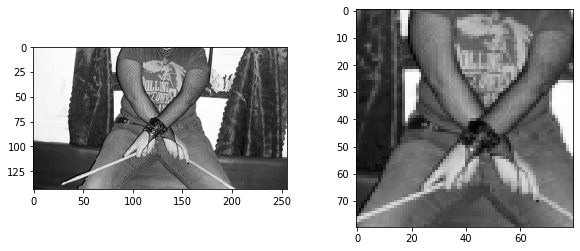

In [148]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(randomNaturalImages[15]['image'], cmap='gray')
axs[1].imshow(transformedImages[15]['image'].squeeze(0), cmap='gray')

## Masking procedure:
Mask the MEIs with their thresholded mask, then mask/contrast normalize the natural images with this mask for fair comparison

Re-norm the masked MEIs 

In [151]:
from src.mei_mask_utils import process_all_units

# Setup parameters
param_config = {
    'zscore_thresh': 0.95,
    'gaussian_sigma': 2,
    'final_image_norm': 19
}

# Process all units in all ensembles
meiMaskDictionary = process_all_units(ensemble_list, selected_indices, MEI_dictionary, param_config)
        

100%|██████████| 6/6 [00:00<00:00, 73.81it/s]

Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  8 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  9 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  aeda98c1c8cfb3798372c2a413006734  Unit:  1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  8 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  2 [1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  9 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  0 [1, 2, 3, 4, 5, 6, 7, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Ensemble:  52d8a77057f826fa06d4de5443f6c548  Unit:  1 [1]
Fewer than 2 m

# Plot the masked MEIs that were generated from each model and for each neuron

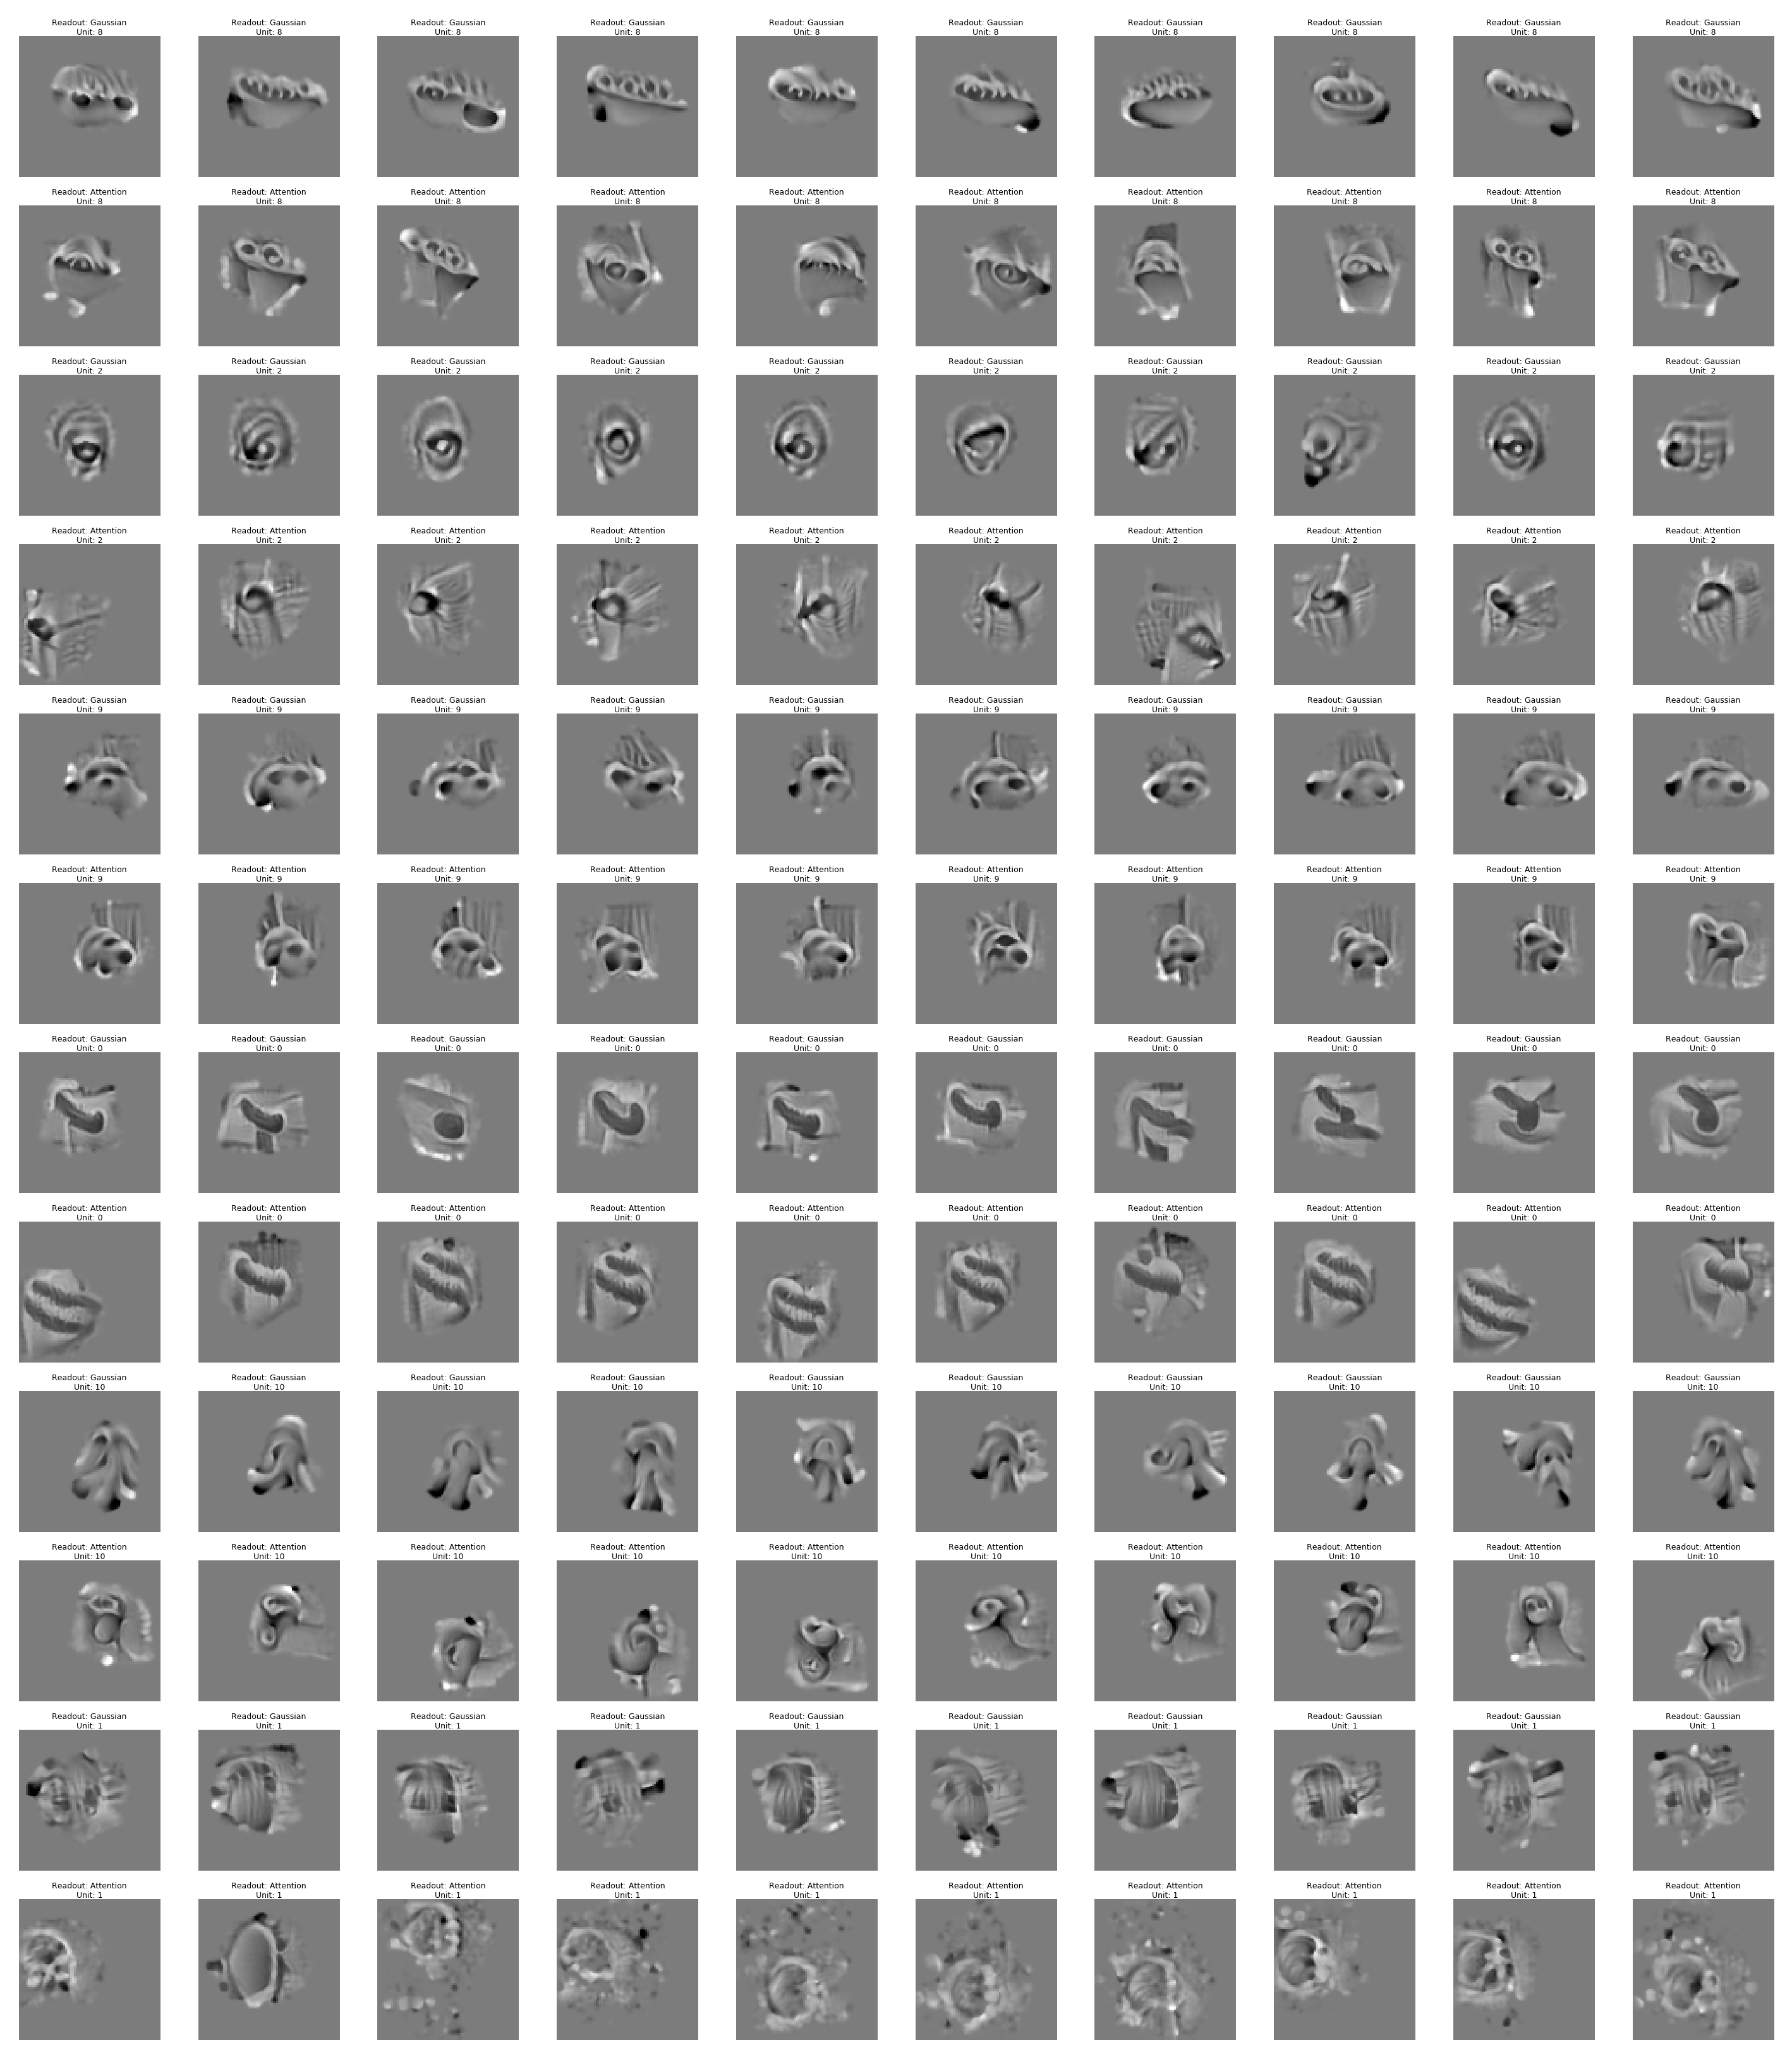

In [152]:
fig, axs = plt.subplots(len(selected_indices)*2, 10, figsize=(12, 14), dpi=300)
readouts = ['Gaussian', 'Attention']
counter = 0
unitCounter = 0
ensembleCounter = 0
for i, ax in enumerate(axs.ravel()):
    mask = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['masked_meis'][counter]
    ax.imshow(mask, cmap='gray', vmin=z_0, vmax=z_255)

    ax.set_title(('Readout: ' + readouts[ensembleCounter] + '\n' + 'Unit: ' + str(selected_indices[unitCounter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
    ax.axis('off')
     
    if ensembleCounter == 1 and counter == 9:
        unitCounter += 1
        ensembleCounter = 0
        counter = 0
    elif ensembleCounter == 0 and counter == 9:
        ensembleCounter += 1
        counter = 0
    else:
        counter += 1
plt.savefig(('MEI_masks_gaussian_resnet_dataset_'+ str(dataset_hash) + '.pdf'), bbox_inches='tight')

## Select the best visual region to present each of the 10 masks for each neuron: using a Gaussian validator network

#### Define a shift function that translates the mask across the image to show it in different regions in order to choose the best one

In [154]:
from itertools import product
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.ndimage import center_of_mass

def get_all_shifts(mei, start, end, step):
    x = np.arange(start, end, step)
    meis = np.zeros((len(x)**2, *mei.shape[-2:]))
    shifts = np.zeros((len(x)**2, 2))
    if len(mei.shape) != 2:
        mei = mei.squeeze()
    if len(mei.shape) != 2:
        raise ValueError("the mei must be either a 2d array or a 4d array of size (1, 1, h, w)")
    
    for i, (x_i, y_i) in enumerate(product(x,x)):
        meis[i] = shift(mei, (x_i, y_i))
        shifts[i] = np.array([x_i, y_i])
    return meis, shifts

#### Shift the gaussian generator MEIs and attention MEIs in a 30x30 grid with a two-pixel stride to get the 10 best MEIs (based on gaussian validator model responses)

In [155]:
for ensemble in ensemble_list:
    for unit_index in tqdm(selected_indices):
        best_masked_meis_unit = []
        best_masks_unit = []
        best_shifted_masked_meis_response = []
        
        meis = torch.from_numpy(np.array(meiMaskDictionary[ensemble][unit_index]['nonclipped_masked_meis'])) #used to be ['masked_meis']))
        masks = torch.from_numpy(np.array(meiMaskDictionary[ensemble][unit_index]['nonclipped_masks'])) #used to be ['masks']))
        
        all_outputs = []
        for mei in range(len(meis)):
            shifted_meis, all_shifts = get_all_shifts(meis[mei].squeeze(), -30,30,2)
            shifted_meis = torch.from_numpy(shifted_meis).to(torch.float32).unsqueeze(1)
            
            with torch.no_grad():
                output = models[gaussValidatorEnsemble](shifted_meis.cuda(), data_key=data_key)[..., unit_index].cpu()

            best_shifted_mei_index = np.argmax(output)
            best_shifted_mei_response = np.max(output.numpy())
            best_shifted_masks = shift(masks[mei], all_shifts[best_shifted_mei_index])
            best_masked_meis = shifted_meis[best_shifted_mei_index].squeeze(0)
            
            best_shifted_masked_meis_response.append(best_shifted_mei_response)
            best_masked_meis_unit.append(best_masked_meis)
            best_masks_unit.append(best_shifted_masks)
            all_outputs.append(best_shifted_mei_response)
        
        best_mei_response_index = np.argmax(all_outputs)
        
        meiMaskDictionary[ensemble][unit_index]['best_shifted_masked_meis_responses'] = all_outputs
        meiMaskDictionary[ensemble][unit_index]['best_shifted_masked_meis'] = best_masked_meis_unit
        meiMaskDictionary[ensemble][unit_index]['best_shifted_masks'] = best_masks_unit
        meiMaskDictionary[ensemble][unit_index]['single_best_masked_mei'] = best_masked_meis_unit[best_mei_response_index]
        meiMaskDictionary[ensemble][unit_index]['single_best_mask'] = best_masks_unit[best_mei_response_index]
        meiMaskDictionary[ensemble][unit_index]['single_best_dj_key'] = meiMaskDictionary[ensemble][unit_index]["datajoint_keys"][best_mei_response_index]


100%|██████████| 6/6 [00:37<00:00,  6.33s/it]


# Plot the shifted MEIs

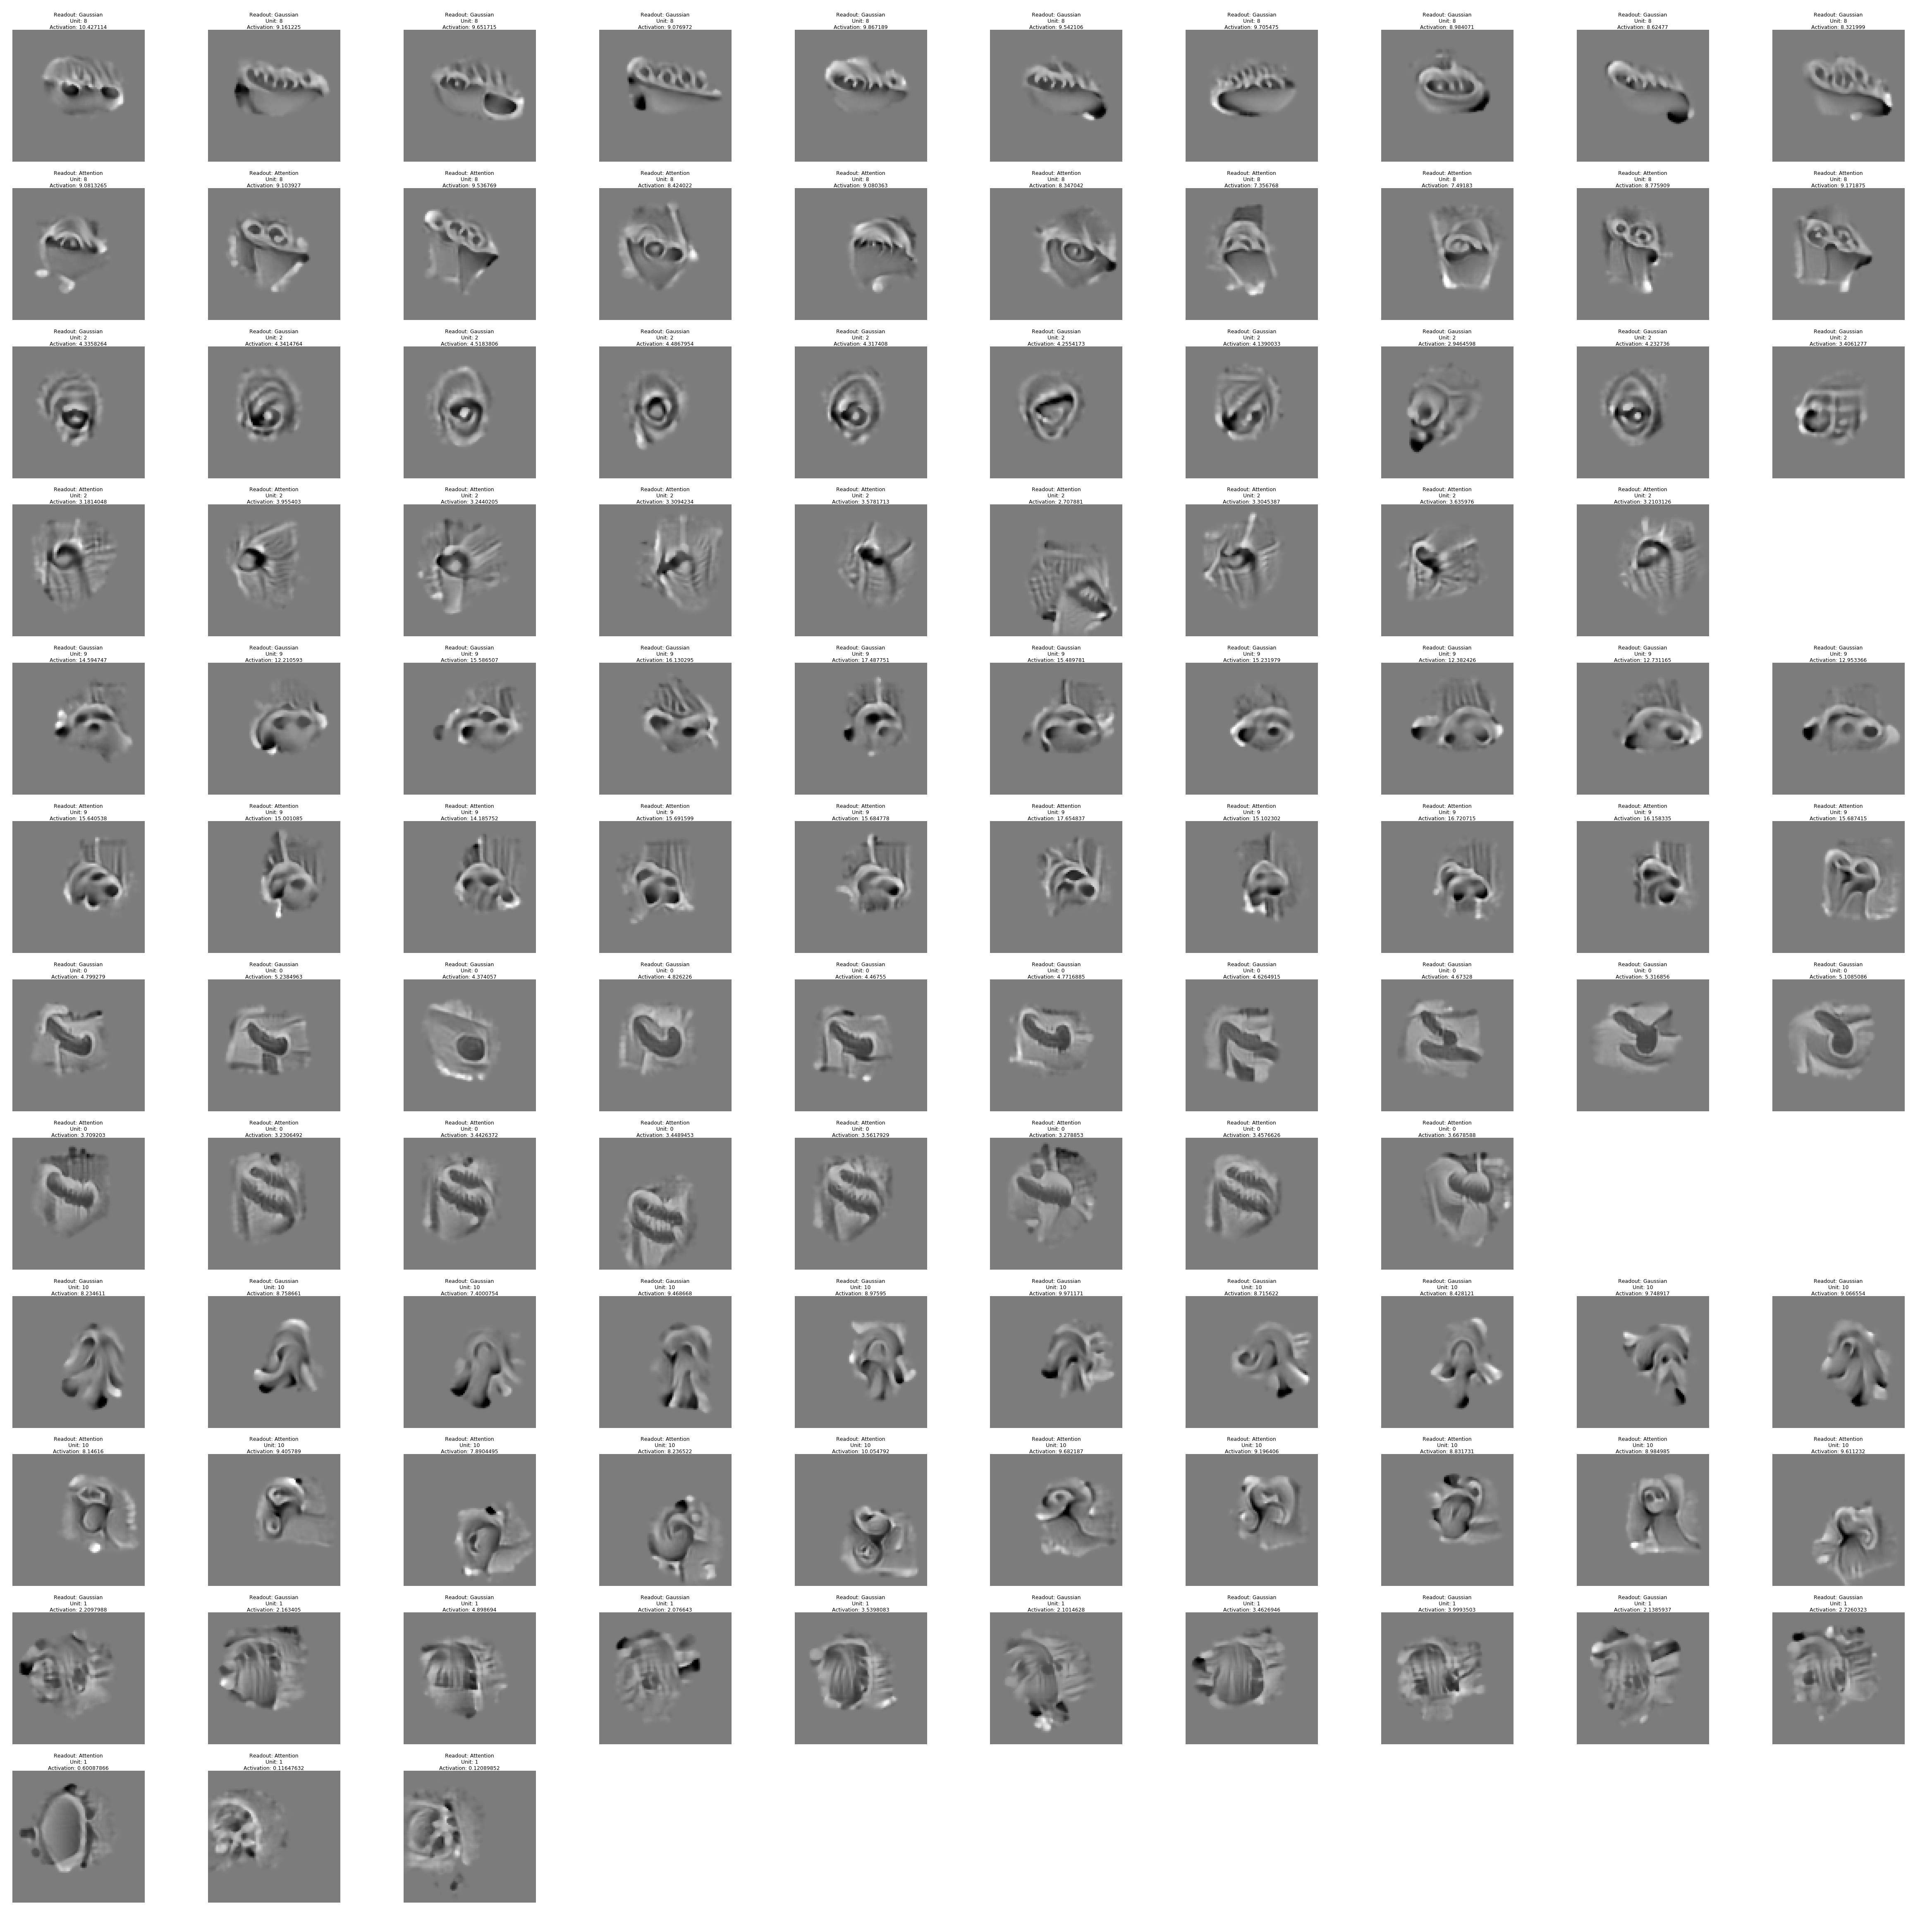

In [156]:
from matplotlib import gridspec

xaxis = []
yaxis = len(selected_indices)*2

for neuron in meiMaskDictionary[ensemble_list[0]].keys():
    xaxis.append(len(meiMaskDictionary[ensemble_list[0]][neuron]['nonclipped_masked_meis']))
        
fig, axes = plt.subplots(yaxis, max(xaxis), figsize=(20, 20), dpi=300)
    

for col in range(yaxis):
    for row in range(max(xaxis)):
        axes[col][row].axis('off')
        
firstIndices = [0, 2, 4, 6, 8, 10]
secondIndices = [1, 3, 5, 7, 9, 11]
#correlationCounter = 0

counter = 0
for neuron in meiMaskDictionary[ensemble_list[0]].keys():
    meiCounter = 0
    for mei in meiMaskDictionary[ensemble_list[0]][neuron]['best_shifted_masked_meis']:
        axes[firstIndices[counter]][meiCounter].imshow((mei), 
                                                  cmap='gray', vmin=z_0, vmax=z_255)
        axes[firstIndices[counter]][meiCounter].set_title(('Readout: ' + readouts[0] + '\n' + 'Unit: ' + str(neuron)
                 + '\n' + 'Activation: ' + str(meiMaskDictionary[ensemble_list[0]][neuron]['best_shifted_masked_meis_responses'][meiCounter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
        meiCounter = meiCounter + 1
    counter += 1

counter = 0
for neuron in meiMaskDictionary[ensemble_list[1]].keys():
    meiCounter = 0
    for mei in meiMaskDictionary[ensemble_list[1]][neuron]['nonclipped_masked_meis']:
        axes[secondIndices[counter]][meiCounter].imshow((mei), 
                                                  cmap='gray', vmin=z_0, vmax=z_255)
        axes[secondIndices[counter]][meiCounter].set_title(('Readout: ' + readouts[1] + '\n' + 'Unit: ' + str(neuron)
         + '\n' + 'Activation: ' + str(meiMaskDictionary[ensemble_list[1]][neuron]['best_shifted_masked_meis_responses'][meiCounter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
        meiCounter = meiCounter + 1
    counter += 1
#plt.savefig(('MEI_NONCLIPPED_masks_gaussian_resnet_dataset_'+ str(dataset_hash) + '.pdf'), bbox_inches='tight')
plt.savefig(('Best_NONCLIPPED_MEI_masks_gaussian_resnet_dataset_'+ str(dataset_hash) + '.pdf'), bbox_inches='tight')

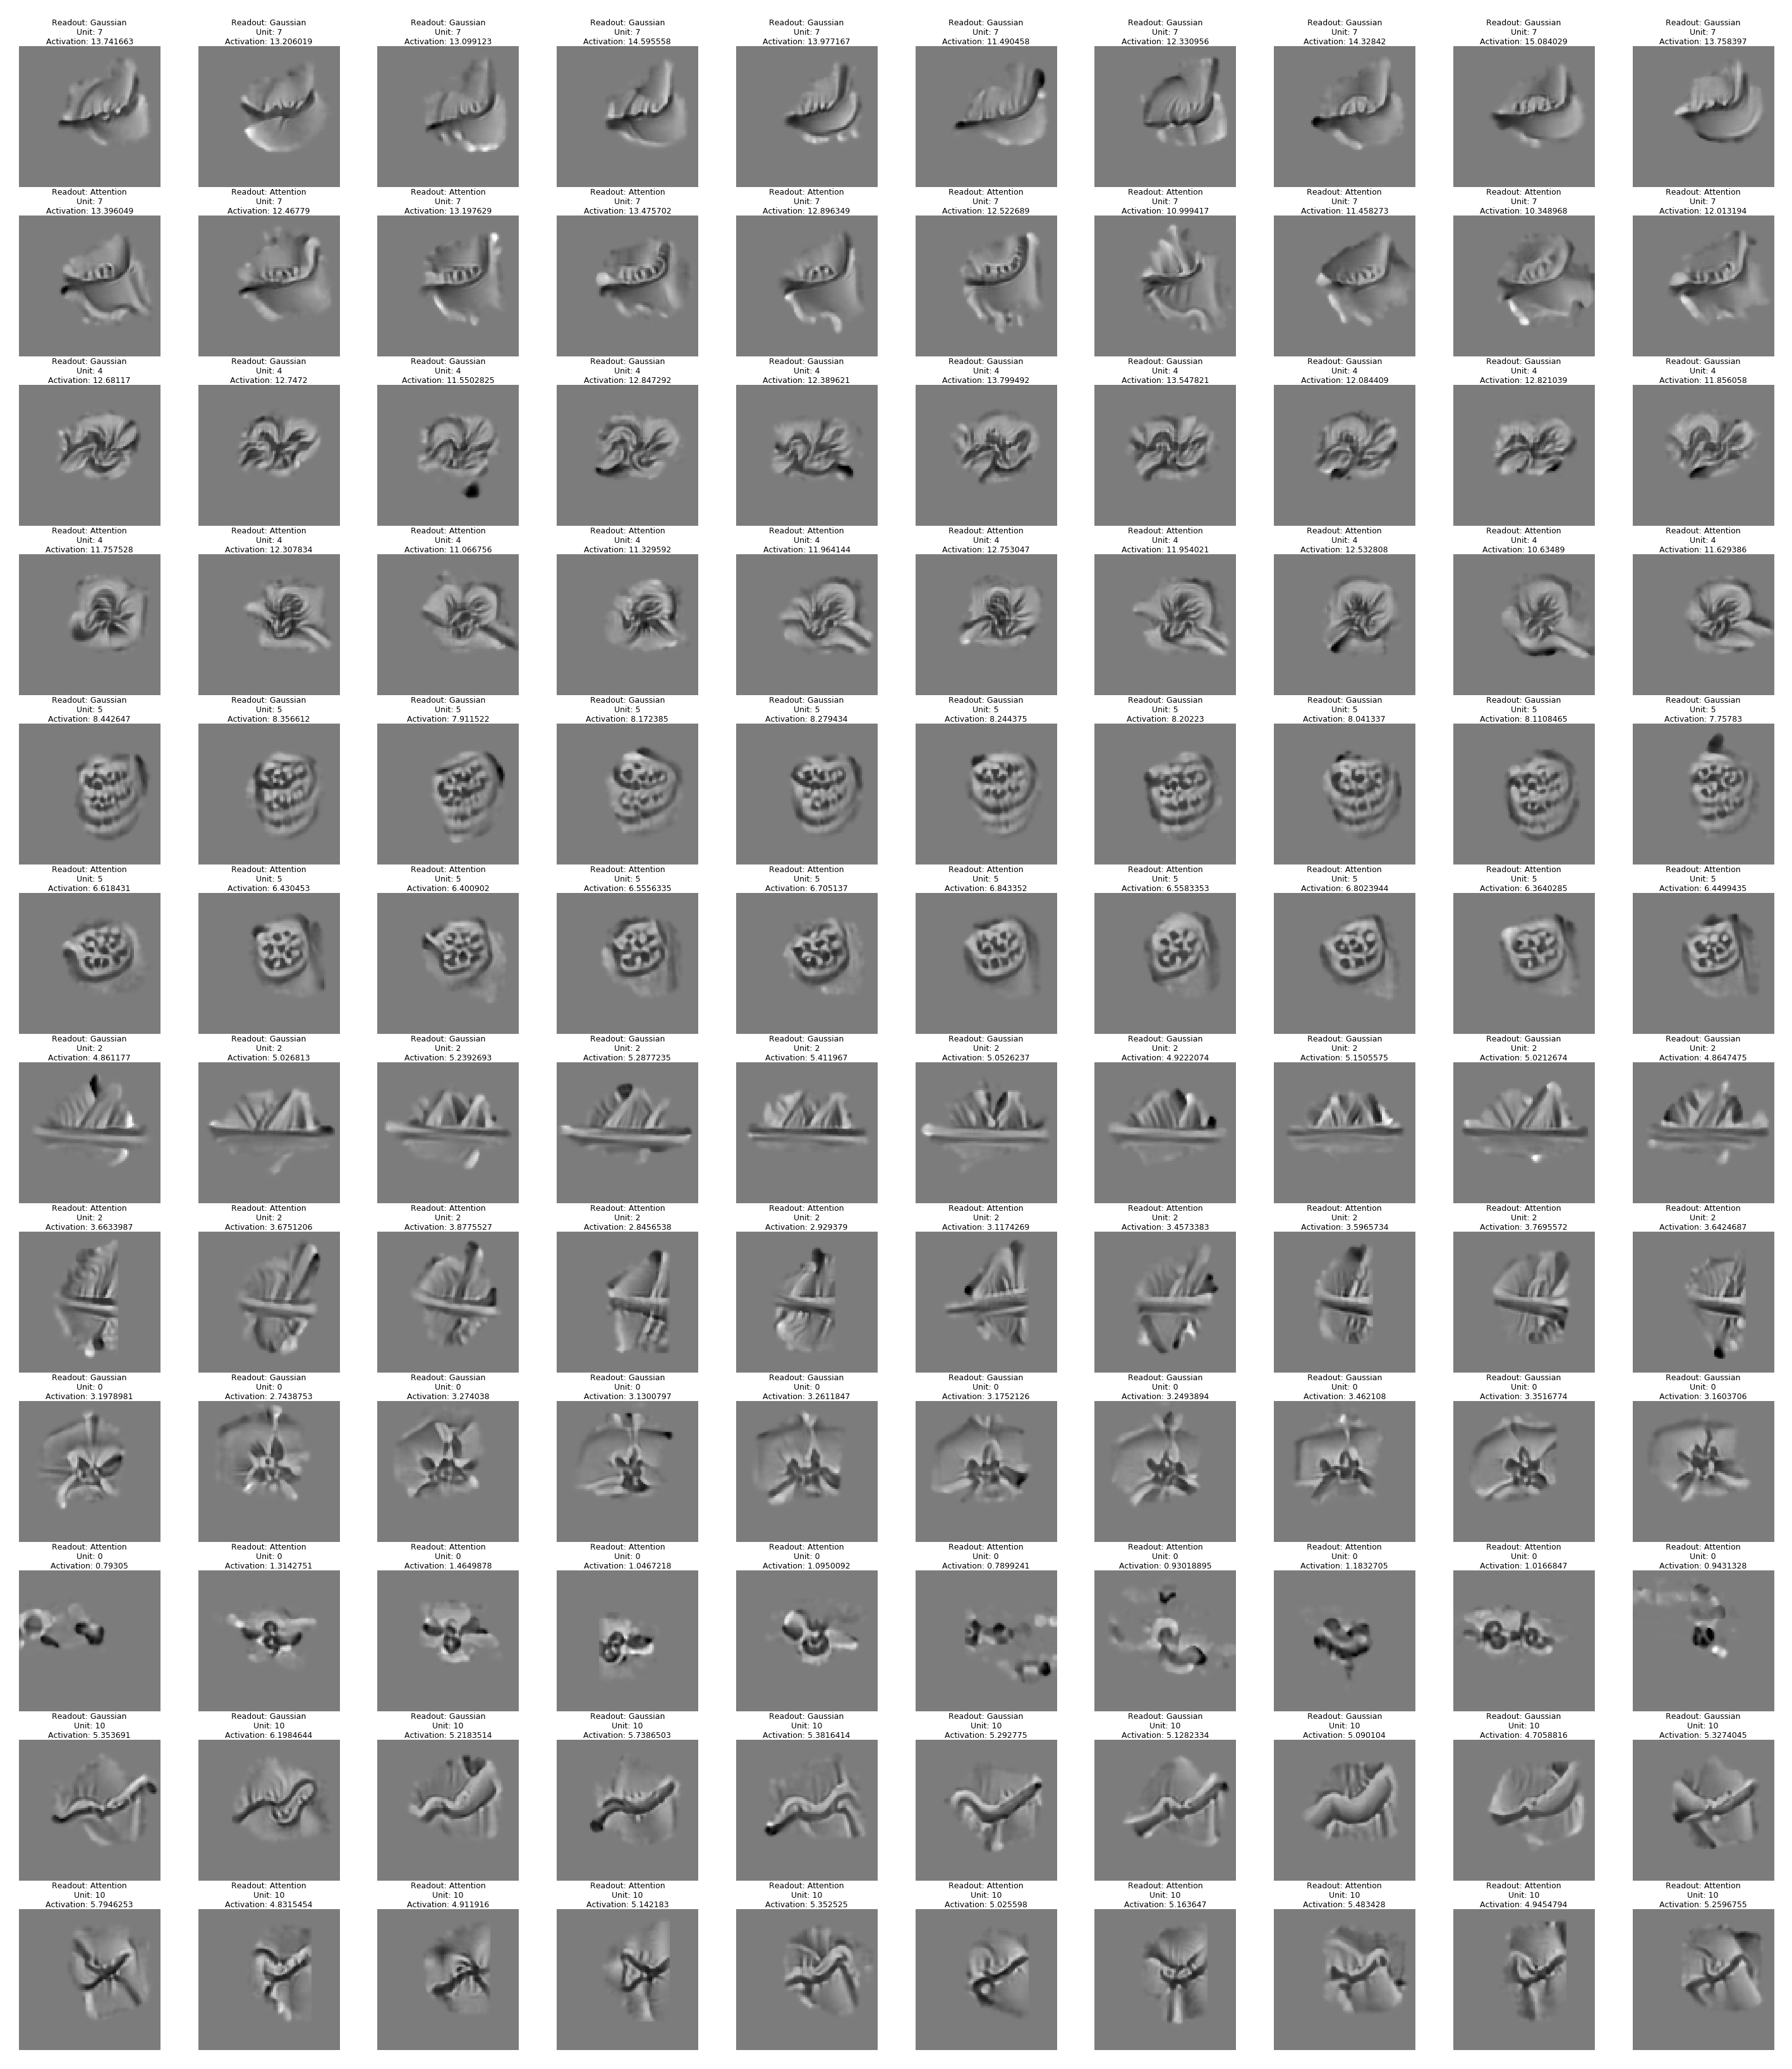

In [132]:
fig, axs = plt.subplots(len(selected_indices)*2, 10, figsize=(12, 14), dpi=300)
readouts = ['Gaussian', 'Attention']
counter = 0
unitCounter = 0
ensembleCounter = 0
for i, ax in enumerate(axs.ravel()):
    mask = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['best_shifted_masked_meis'][counter]
    ax.imshow(mask, cmap='gray', vmin=z_0, vmax=z_255)

    ax.set_title(('Readout: ' + readouts[ensembleCounter] + '\n' + 'Unit: ' + str(selected_indices[unitCounter])
                 + '\n' + 'Activation: ' + str(meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['best_shifted_masked_meis_responses'][counter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
    ax.axis('off')
    
    if ensembleCounter == 1 and counter == 9:
        unitCounter += 1
        ensembleCounter = 0
        counter = 0
    elif ensembleCounter == 0 and counter == 9:
        ensembleCounter += 1
        counter = 0
    else:
        counter += 1
plt.savefig(('Best_MEI_masks_gaussian_resnet_dataset_'+ str(dataset_hash) + '.pdf'), bbox_inches='tight')

## Select the top 7 masks from the Gaussian masked natural images

### 1. Mask all natural images with the 10 best gaussian generator masks

In [157]:
# For each mask, search all 5k images for the best masked image; thus, 10 masks for each unit
naturalImagesDictionary = {gaussGeneratorEnsemble: {unit_index:{} for unit_index in selected_indices}}
for unit_index in tqdm(selected_indices):
    maskedRenormedNaturalImages = torch.empty((5000, len(meiMaskDictionary[gaussGeneratorEnsemble][unit_index]['best_shifted_masks']), h, w))

    keys = []
    allMasks = meiMaskDictionary[gaussGeneratorEnsemble][unit_index]['best_shifted_masks']
    #selectedMaskIndices = meiMaskDictionary[ensemble][unit_index]['nonclipped_masks_indices']
    #selectedMasks = [allMasks[i] for i in selectedMaskIndices]

    for i, mask in enumerate(allMasks):

        for image in range(len(transformedImages)):
            maskedRenormedNaturalImages[image, i, ...] = re_norm(transformedImages[image]['image'].squeeze(0) * mask, 19)
            selectedKeys = [meiMaskDictionary[ensemble][unit_index]['datajoint_keys'][i] for i in range(len(allMasks))]
            thisKey = {k:v for (k,v) in selectedKeys[i].items()}
            thisKey['image_id'] = transformedImages[image]['image_id']
            thisKey['image_class'] = transformedImages[image]['image_class']
            keys.append(thisKey)

    naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['images'] = maskedRenormedNaturalImages
    naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['datajoint_keys'] = keys

100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


### 2. Select the top 7 masked natural images

In [159]:
%%time
warnings.filterwarnings('ignore')

# For each image, search each mask for the best
maskedRenormedImageDict = {gaussGeneratorEnsemble: {unit_index: {} for unit_index in selected_indices}}

n_total_natural_images = len(transformedImages)
    
for unit_index in tqdm(selected_indices):        
    bestMasks = np.zeros((n_total_natural_images, h, w))
    bestMEIMasks = np.zeros((n_total_natural_images, h, w))
    maxResponses = np.zeros((n_total_natural_images))
    masks = meiMaskDictionary[gaussGeneratorEnsemble][unit_index]['best_shifted_masks']
    
    maskedRenormedNaturalImages = naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['images']

    #datajoint keys are a list of 50k (NEW: or fewer than 50k depending on how many masks are used), corresponding to 5k images for each mask (5k for mask 1 + 5k for mask 2 + ...)
    all_datajoint_keys = naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['datajoint_keys']

    #initialize 5k random datajoint keys (this will change to be the datajoint keys of the 5k images with their best masks)
    datajoint_keys_best_mask = np.array(naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['datajoint_keys'][0:5000])

    allNaturalImageResponses = np.zeros((n_total_natural_images, len(masks)))
    for mask in range(len(masks)):            
        datajoint_keys_mask = np.array(naturalImagesDictionary[gaussGeneratorEnsemble][unit_index]['datajoint_keys'][(mask*5000):(mask*5000)+5000])
        responses = []
        for batch in range(0, 5000, 1000):
            with torch.no_grad():    
                responses.append(models[gaussGeneratorEnsemble](maskedRenormedNaturalImages[batch:batch+1000, mask, ...].unsqueeze(1).cuda())[:, unit_index])
        responses = torch.cat(responses).cpu().numpy()
        updatedBestResponseIndices = np.where(responses > maxResponses)[0]
        datajoint_keys_best_mask[updatedBestResponseIndices] = datajoint_keys_mask[updatedBestResponseIndices]
        allNaturalImageResponses[:, mask] = responses
        
        bestMEIMasks[updatedBestResponseIndices] = masks[mask]
        bestMasks[updatedBestResponseIndices] = maskedRenormedNaturalImages[updatedBestResponseIndices, mask, ...]
        maxResponses[updatedBestResponseIndices] = responses[updatedBestResponseIndices]

    best_image_argsort = np.flipud(np.argsort(maxResponses))[:param_config['n_best_images_selected']]
    datajoint_keys_best_masks = np.array(datajoint_keys_best_mask)[best_image_argsort]
    topResponses = maxResponses[best_image_argsort]
    topMasks = bestMasks[np.copy(best_image_argsort)] 
    topMEIMasks = bestMEIMasks[np.copy(best_image_argsort)]

    maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]['images_best_mask'] = topMasks #bestMasks; CHANGE: now we pick top 7 instead of top 10 and 2 random
    maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]['responses_best_mask'] = topResponses #maxResponses
    maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]['responses_all_masks'] = allNaturalImageResponses #allResponses
    maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]['mei_masks'] = topMEIMasks
    maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]['datajoint_keys'] = datajoint_keys_best_masks
        

100%|██████████| 6/6 [02:39<00:00, 26.56s/it]

CPU times: user 3min 14s, sys: 2.3 s, total: 3min 17s
Wall time: 2min 39s


# Visualize the MEIs, MEI masks, and natural image control stimuli

#### First visualize the top 7 masked natural image control stimuli for each neuron

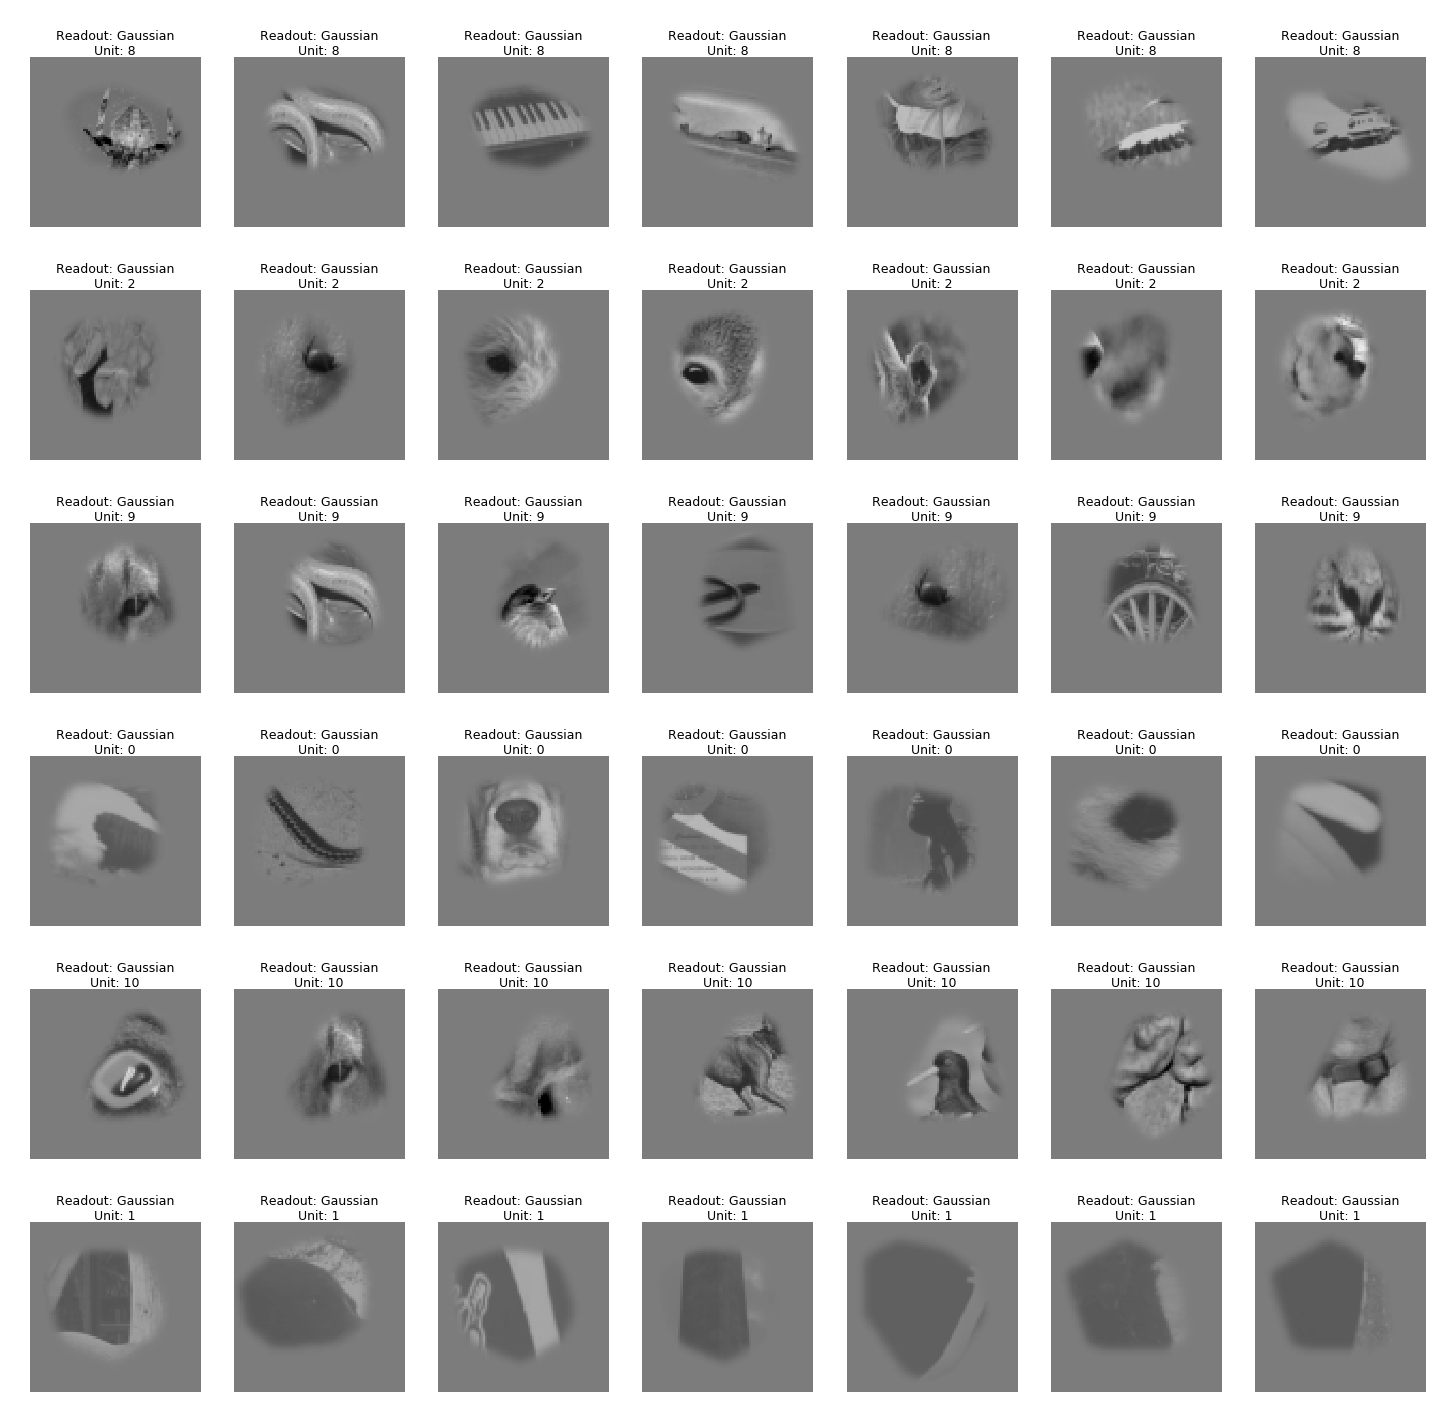

In [160]:
fig, axs = plt.subplots(len(selected_indices), 7, figsize=(6, 6), dpi=300)
readouts = ['Gaussian', 'Attention']
counter = 0
unitCounter = 0
ensembleCounter = 0
for i, ax in enumerate(axs.ravel()):
    mask = maskedRenormedImageDict[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['images_best_mask'][counter]
    ax.imshow(mask, cmap='gray', vmin=z_0, vmax=z_255)

    ax.set_title(('Readout: ' + readouts[ensembleCounter] + '\n' + 'Unit: ' + str(selected_indices[unitCounter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
    ax.axis('off')
    
    if counter == 6:
        unitCounter += 1
        counter = 0
    else:
        counter += 1

#plt.savefig('top10maskedNaturalImages_dataset_' + str(dataset_hash) + '.pdf', bbox_inches='tight')
plt.savefig('top10NonclippedMaskedNaturalImages_dataset_' + str(dataset_hash) + '.pdf', bbox_inches='tight')

### Then visualize all 10 original masked MEIs next to the top 10 masked/shifted MEIs for each readout for each neuron

This is done to check that the mask matches the size/shape of the MEI

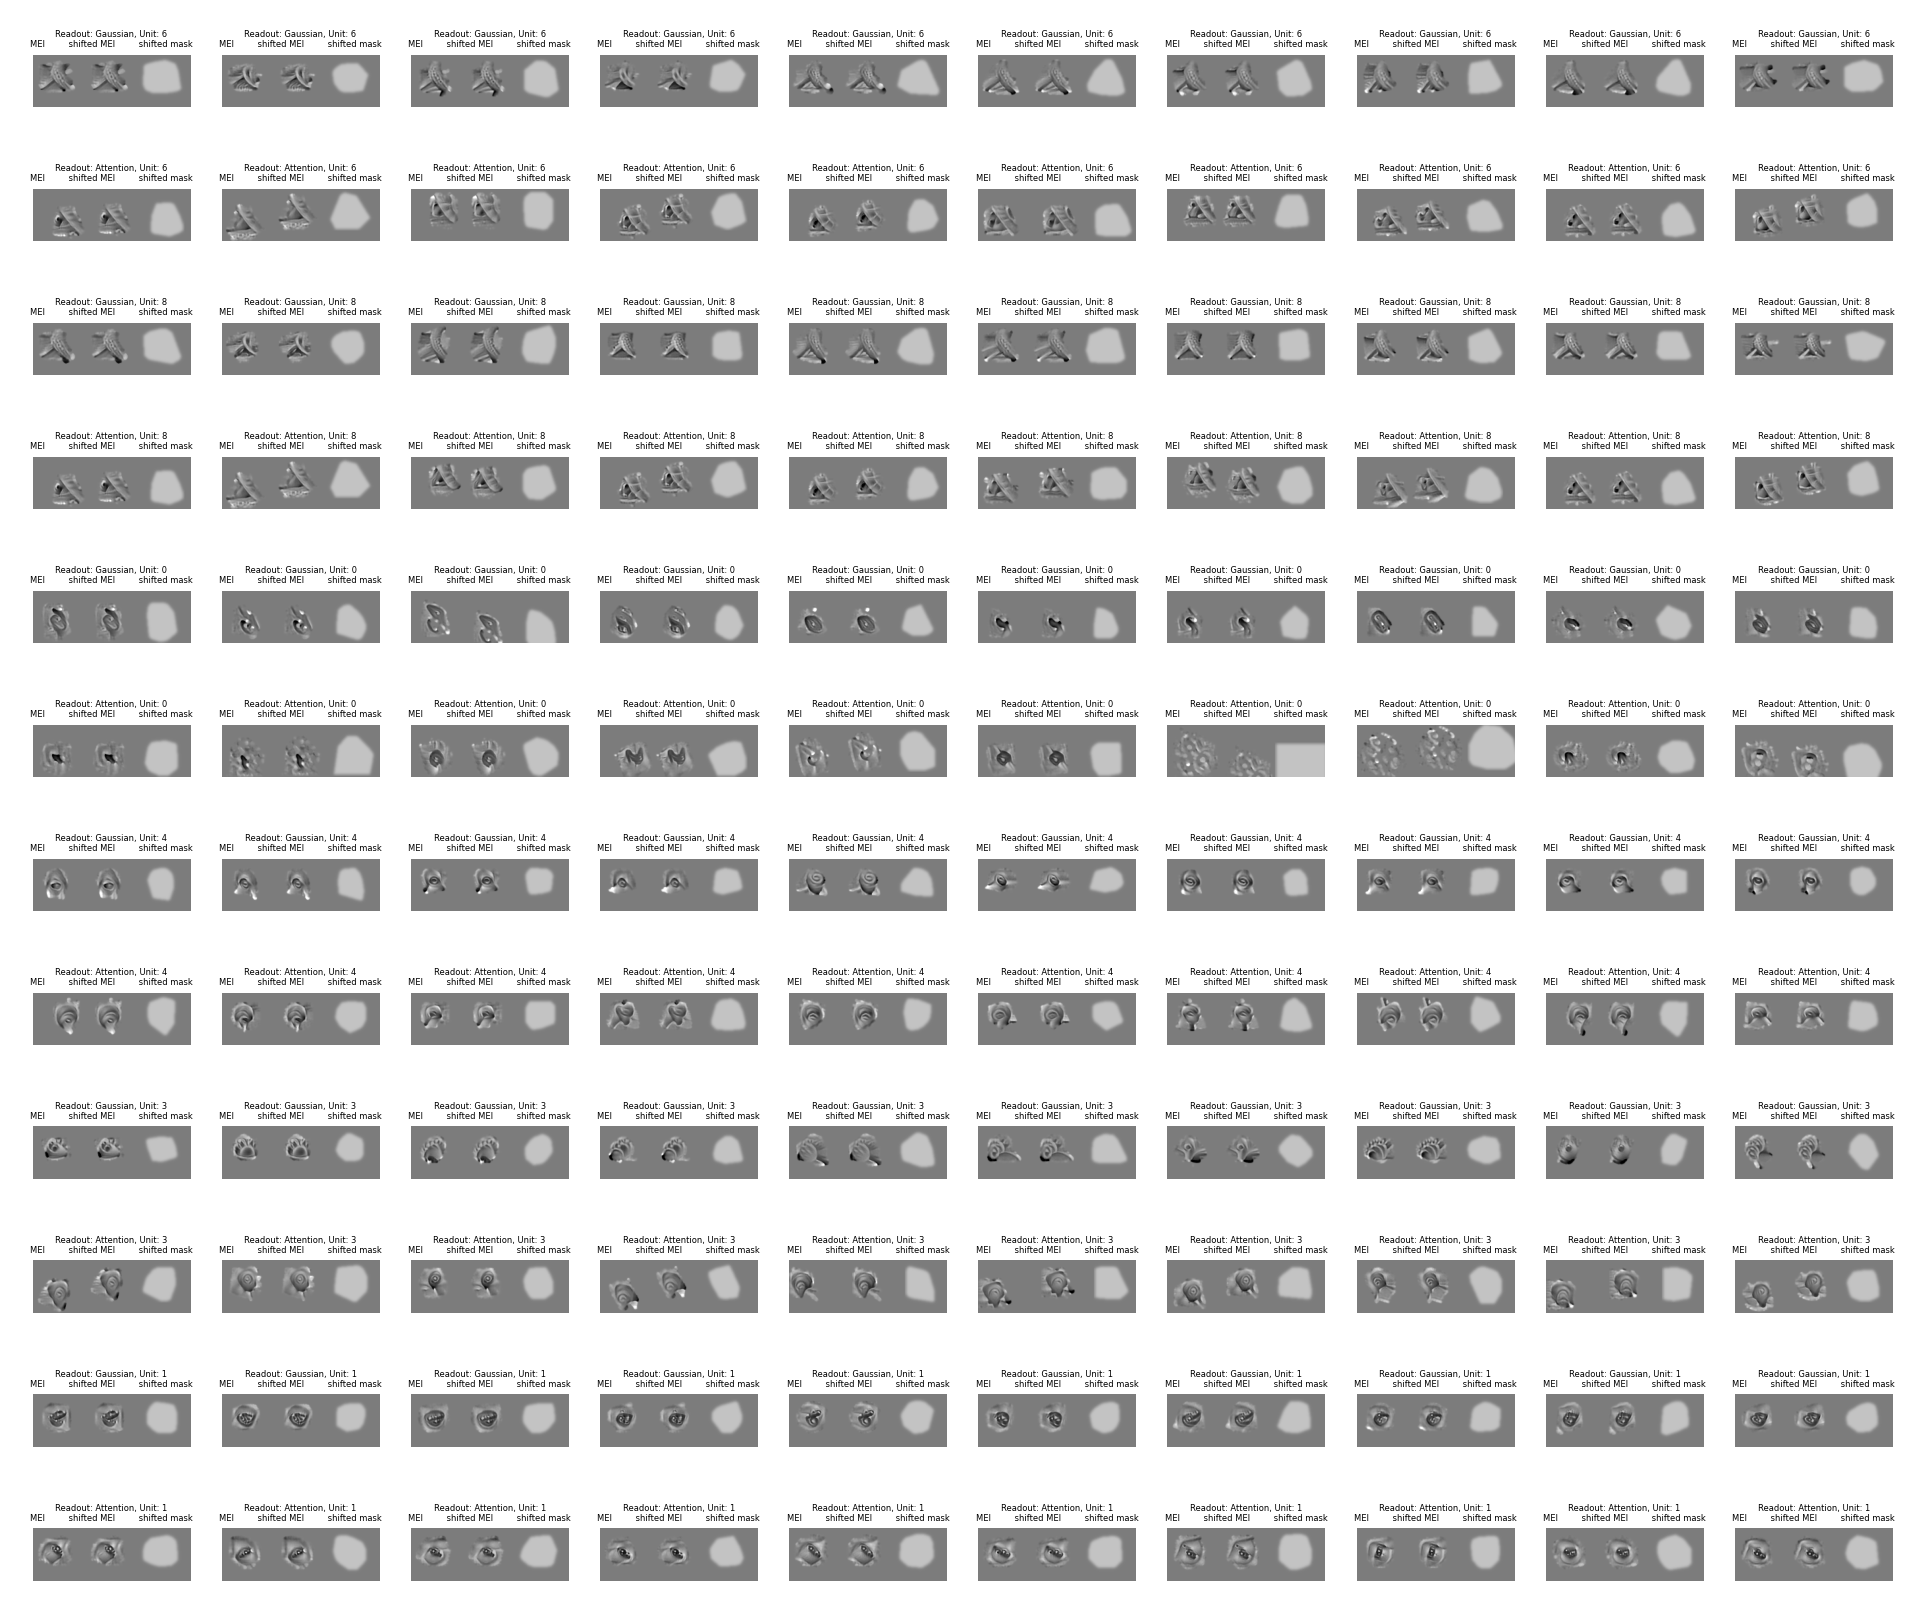

In [157]:
fig, axs = plt.subplots(len(selected_indices)*2, 10, figsize=(8, 7), dpi=300)
readouts = ['Gaussian', 'Attention']
counter = 0
unitCounter = 0
ensembleCounter = 0
for i, ax in enumerate(axs.ravel()):
    original_mei = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['masked_meis'][counter]
    best_mei = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['best_shifted_masked_meis'][counter]
    best_mask = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['best_shifted_masks'][counter]
    best_shifted_MEI_and_mask = np.hstack([original_mei, best_mei, best_mask])
                                           
    ax.imshow(best_shifted_MEI_and_mask, cmap='gray', vmin=z_0, vmax=z_255)

    ax.set_title(('Readout: ' + readouts[ensembleCounter] + ', Unit: ' + str(selected_indices[unitCounter]) + '\n' + 'MEI         shifted MEI         shifted mask'), fontdict={'verticalalignment': 'top'}, fontsize=2)
    ax.axis('off')
    
    if ensembleCounter == 1 and counter == 9:
        unitCounter += 1
        ensembleCounter = 0
        counter = 0
    elif ensembleCounter == 0 and counter == 9:
        ensembleCounter += 1
        counter = 0
    else:
        counter += 1
plt.savefig('sanityCheckMEIsVsBestMEIsAndMasks.pdf', bbox_inches='tight')

# Shift the chosen MEIs in a circular grid determined by the size of the neuron's receptive field, in order to show MEIs at different locations

In [162]:
rf_size = neuronal_data['rf_size']
print('RF size: ', rf_size)
increment = .3
ppd = 5.7
padsize = 10


for ensemble in ensemble_list:
    for unit_index in selected_indices:
        bestMaskedMEI = meiMaskDictionary[ensemble][unit_index]['single_best_masked_mei']
        bestMask = meiMaskDictionary[ensemble][unit_index]['single_best_mask']
        stacked_mei = np.stack([bestMaskedMEI, bestMask])
        shifted_mei = (shift_based_on_rf(stacked_mei, 
                               rf_size=rf_size,
                               increment=increment,
                               ppd=ppd,
                               padsize=padsize))

        meiMaskDictionary[ensemble][unit_index]['rf_circular_grid_shifted_MEI'] = shifted_mei

RF size:  4.446370901332315


## Visualize the circular grid-shifted MEIs

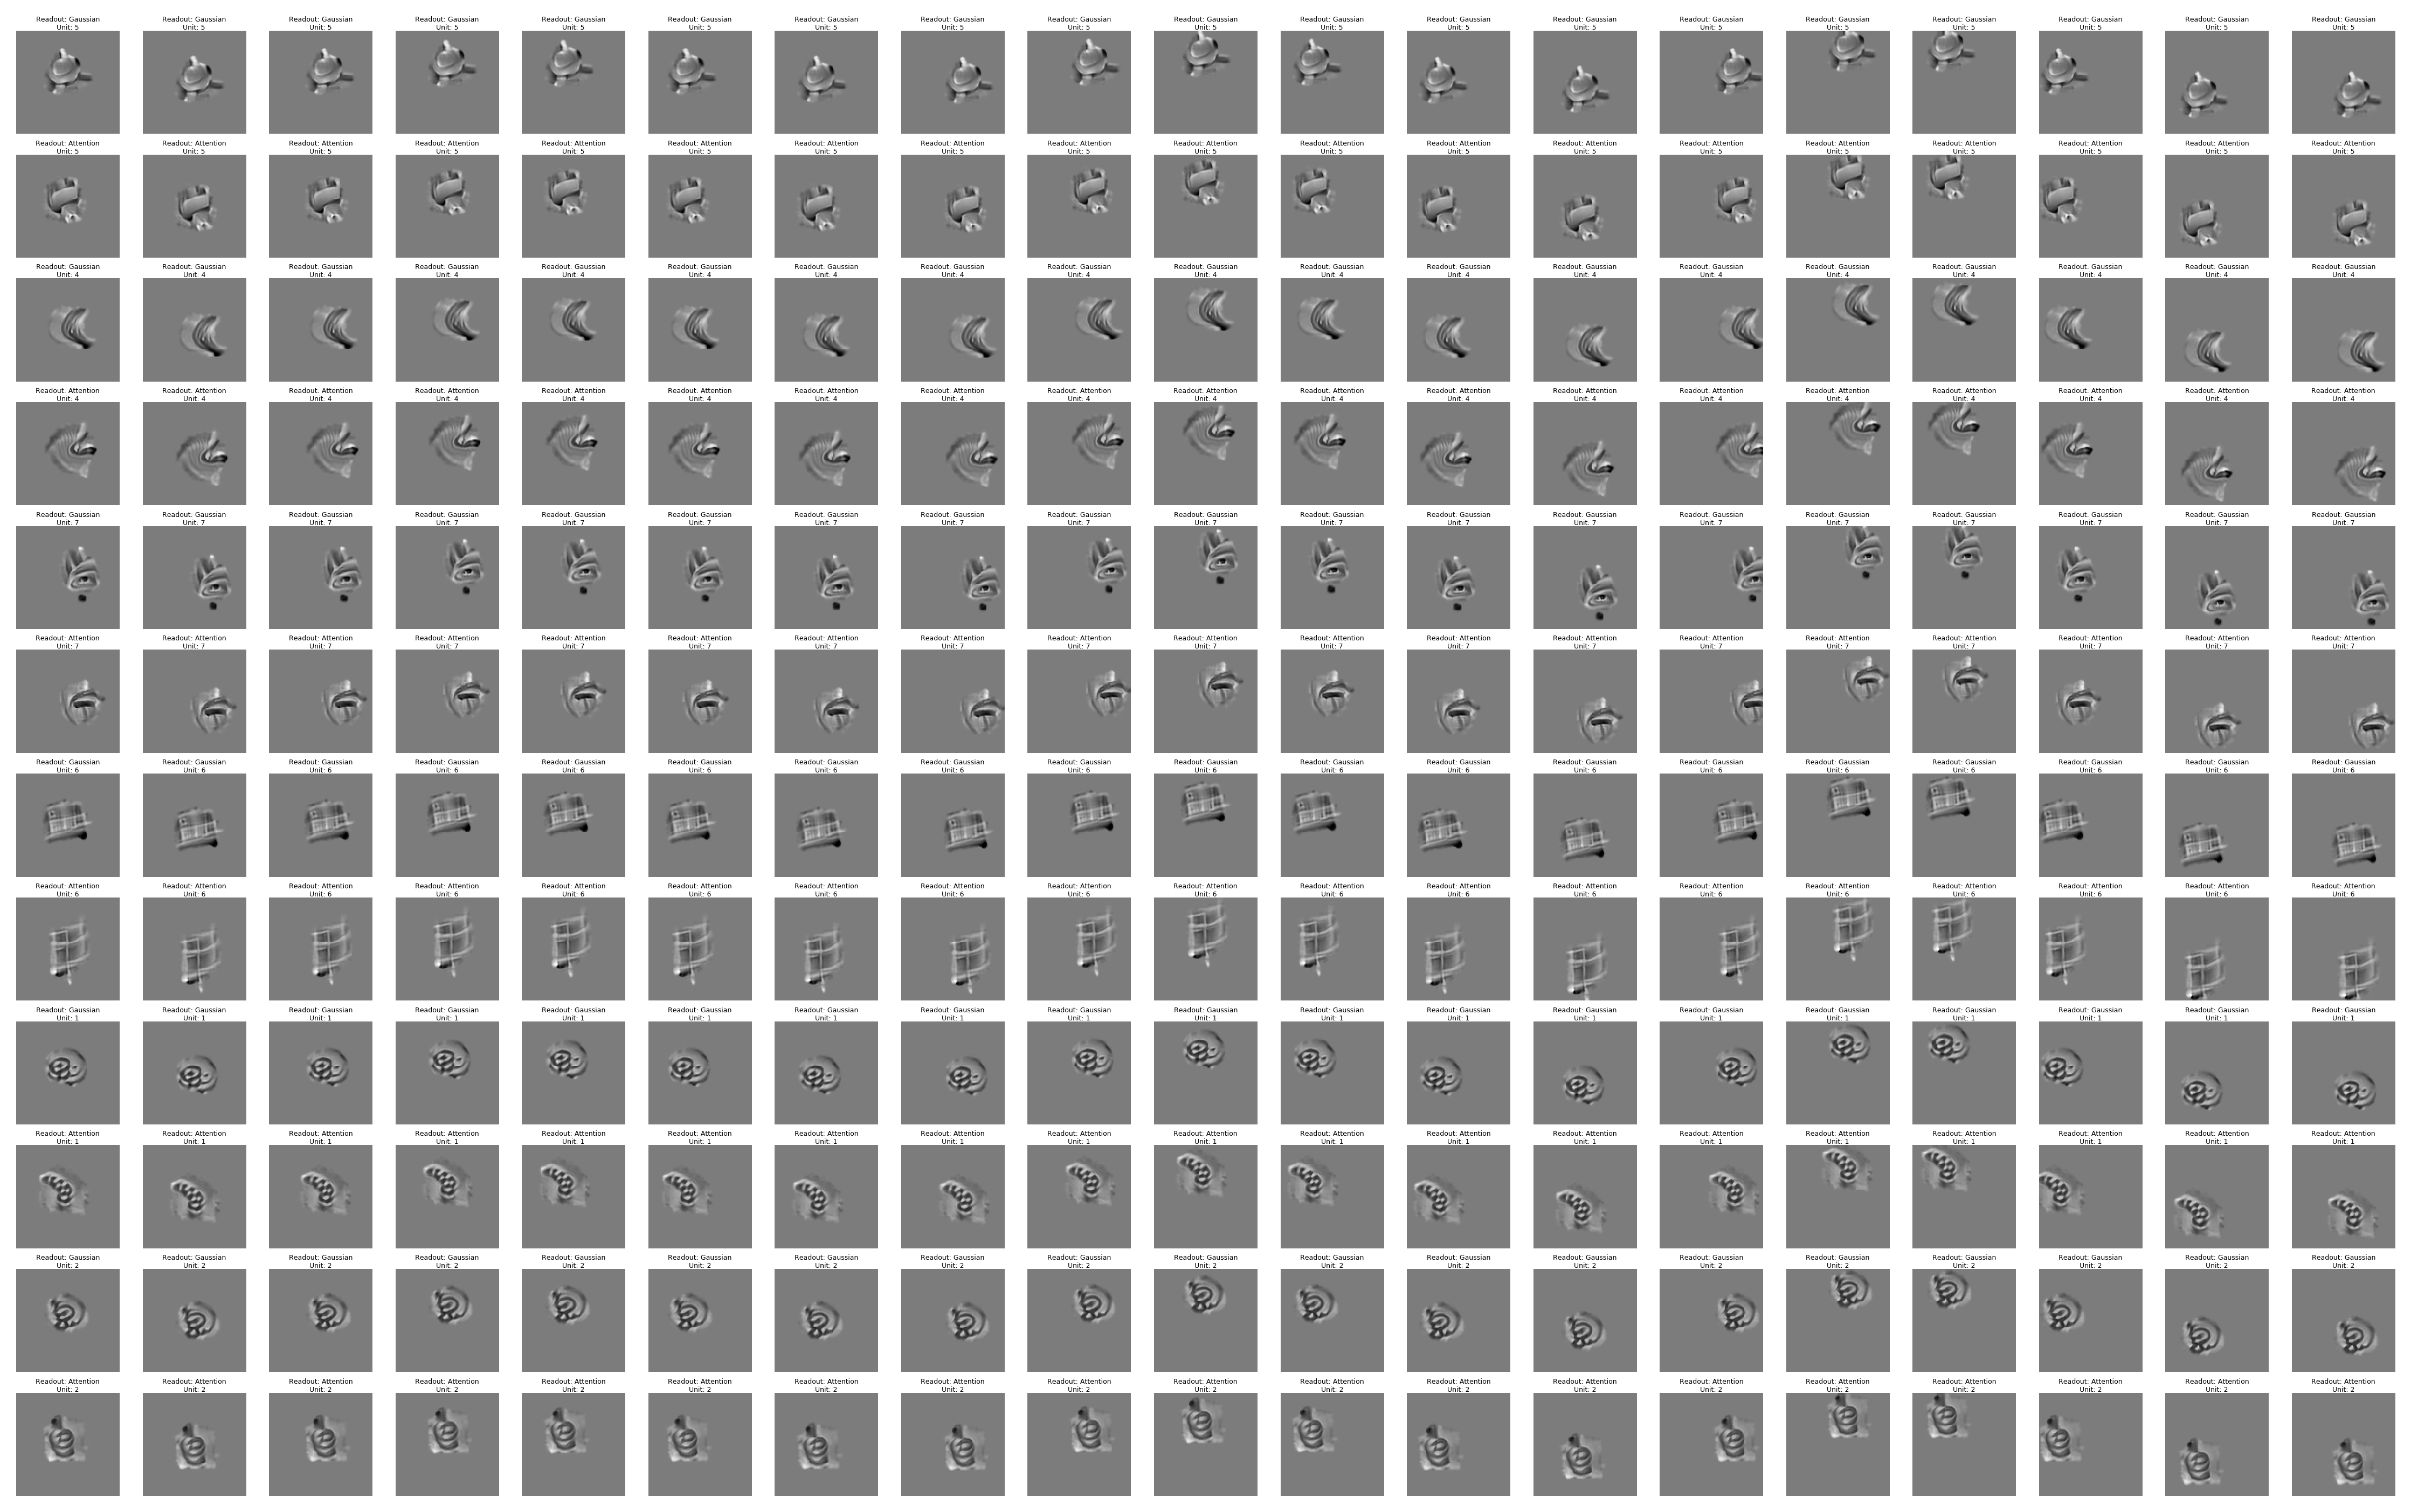

In [132]:
fig, axs = plt.subplots(len(selected_indices)*2, 19, figsize=(19, 12), dpi=300)
readouts = ['Gaussian', 'Attention']
counter = 0
unitCounter = 0
ensembleCounter = 0
attentionEnsemble = 0
for i, ax in enumerate(axs.ravel()):
    shiftedMEI = meiMaskDictionary[ensemble_list[ensembleCounter]][selected_indices[unitCounter]]['rf_circular_grid_shifted_MEI'][0][counter]
    ax.imshow(shiftedMEI, cmap='gray', vmin=z_0, vmax=z_255)

    ax.set_title(('Readout: ' + readouts[ensembleCounter] + '\n' + 'Unit: ' + str(selected_indices[unitCounter])), fontdict={'verticalalignment': 'top'}, fontsize=3)
    ax.axis('off')

    if counter == 18 and not attentionEnsemble:
        ensembleCounter += 1
        attentionEnsemble = 1
        counter = 0
    elif counter == 18 and attentionEnsemble:
        unitCounter += 1
        ensembleCounter -= 1
        attentionEnsemble = 0
        counter = 0
    else:
        counter += 1
        
plt.savefig('circularGridShiftedMEIs_' + str(dataset_hash) + '.pdf', bbox_inches='tight')

---

# Saving Stimuli

---

# Final Image Procressing for Stimulus Presentation

In [163]:
# At this point the images will have already been masked and renormed
def process_for_presentation(img,img_mean=124.34, img_std=70.28):
    # upscale, convert, clip, change type
    height, width = img.shape
    upsampledImage = rescale_image(img, 11.4)
    upsampledHeight, upsampledWidth = upsampledImage.shape

    #Convert image to pixel space
    convertedImage = upsampledImage * img_std + img_mean

    # Convert image to 8-bit
    finalImage = np.round(convertedImage).clip(0,255).astype('uint8')

    return finalImage


# Define database tables to save experimental stimuli

In [165]:
@schema
class RFCLMaskedControl(dj.Manual):
    definition = """
    -> StaticImage.Image
    cl_image_id          : int
    ---
    image_mask           : longblob
    image_mask_key       : longblob
    image                : longblob
    """

@schema
class RFShiftCLMaskedMEI(dj.Manual):
    definition = """
    cl_image_id          : int
    method_fn            : varchar(64)                  # name of the method function
    method_hash          : varchar(32)                  # hash of the method config
    dataset_fn           : varchar(64)                  # name of the dataset loader function
    dataset_hash         : varchar(64)                  # hash of the configuration object
    ensemble_hash        : char(32)                     # the hash of the ensemble
    data_key             : varchar(64)                  # 
    unit_id              : int                          # 
    unit_type            : int                          # 
    mei_seed             : tinyint unsigned             # MEI seed
    ---
    image_mask           : longblob
    shift                : longblob
    image                : longblob
    """

---

# Save the MEIs

In [166]:
RFShiftCLMaskedMEI()

*cl_image_id   *method_fn     *method_hash   *dataset_fn    *dataset_hash  *ensemble_hash *data_key      *unit_id    *unit_type    *mei_seed    image_mask shift      image     
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +---------+ +-----------+ +----------+ +--------+ +--------+ +--------+
50000          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50001          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50002          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50003          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50004          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50005          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50006          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50007          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50008          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50009          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50010          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
50011          mei.methods.gr a9277c97184765 nnvision.datas 28cd21e812dcfc f259f630e18ba2 3733498089386  1           1             30           =BLOB=     =BLOB=     =BLOB=    
   ...
 (Total: 6384)

In [167]:
cl_image_id = 50000 if len(RFShiftCLMaskedMEI()) == 0 else RFShiftCLMaskedMEI.fetch("cl_image_id", order_by="cl_image_id DESC",limit=1)[0] + 1
attentionMEICounts = 0
# Attention
for ensemble in ensemble_list:
    for unit_index in tqdm(selected_indices):
        for j in range(19):
            
            mei = meiMaskDictionary[ensemble][unit_index]["rf_circular_grid_shifted_MEI"][0][j]
            shift = meiMaskDictionary[ensemble][unit_index]["rf_circular_grid_shifted_MEI"][1][j]
            dj_key = meiMaskDictionary[ensemble][unit_index]["single_best_dj_key"]
            full_key = (MEI&dj_key).fetch1("KEY")

            image_mask = meiMaskDictionary[ensemble][unit_index]["single_best_mask"]

            insert_key = dict(cl_image_id=cl_image_id,
                             image_mask=image_mask,
                             image=mei,
                             shift=shift,
                              **full_key)

            RFShiftCLMaskedMEI().insert1(insert_key)

            presentation_mei = process_for_presentation(mei)

            scipy.io.savemat('/mnt/lab/users/kelli/mei/V4_SUA_closed_loop/cnn_resnet_meis_masked_natural_images/%s' % cl_image_id + '.mat', 
                 {'image': presentation_mei})

            cl_image_id += 1
            attentionMEICounts += 1
print(attentionMEICounts)

100%|██████████| 6/6 [00:10<00:00,  1.70s/it]

228


# Save the control stimuli

In [168]:
cl_image_id = 80000 if len(RFCLMaskedControl()) == 0 else RFCLMaskedControl.fetch("cl_image_id", order_by="cl_image_id DESC", limit=1)[0] + 1

attentionControlCount = 0
for unit_index in tqdm(selected_indices):
    for j in range(7):

        control_img = maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]["images_best_mask"][j]
        dj_key = maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]["datajoint_keys"][j]
        
        image_mask_key = (MEI&dj_key).fetch1("KEY")
        image_mask = maskedRenormedImageDict[gaussGeneratorEnsemble][unit_index]["mei_masks"][j]

        insert_key = dict(cl_image_id=cl_image_id,
                          image_id=dj_key["image_id"],
                          image_class=dj_key["image_class"],
                          image_mask=image_mask,
                          image_mask_key=image_mask_key,
                         image=control_img,
                         )
        RFCLMaskedControl().insert1(insert_key)

        presentation_mei = process_for_presentation(control_img)

        scipy.io.savemat('/mnt/lab/users/kelli/mei/V4_SUA_closed_loop/cnn_resnet_meis_masked_natural_images/%s' % cl_image_id + '.mat', 
             {'image': presentation_mei})

        cl_image_id += 1
        attentionControlCount += 1
print(attentionControlCount)

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]

42


# Done.

---

---

---